#Explainable Detection of Online Sexism (EDOS)

The [Explainable Detection of Online Sexism (EDOS)](https://codalab.lisn.upsaclay.fr/competitions/7124) supports the development of English-language models for sexism detection that are more accurate as well as explainable, with fine-grained classifications for sexist content from Gab and Reddit.

The task contains three hierarchical subtasks:

*  TASK A - **Binary Sexism Detection**: a two-class (or binary) classification where systems have to predict whether a post is sexist or not sexist.
*  TASK B - **Category of Sexism**: for posts which are sexist, a four-class classification where systems have to predict one of four categories: (1) threats, (2)  derogation, (3) animosity, (4) prejudiced discussions. 
*  TASK C - **Fine-grained Vector of Sexism**: for posts which are sexist, an 11-class classification where systems have to predict one of 11 fine-grained vectors.


Main Sources:
- https://www.kaggle.com/code/debarshichanda/bert-multi-label-text-classification
- https://huggingface.co/docs/transformers/training


# Imports

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!pip install transformers
!pip install nlpaug
!pip install sacremoses
!pip install torch
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 15.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created whee

In [ ]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab
from torchtext.data.utils import get_tokenizer

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import set_seed, enable_full_determinism # For reproducibility

from keras import layers
from keras.utils.np_utils import to_categorical

import gensim
import gensim.downloader as gloader
import nlpaug.augmenter.word as naw

from typing import Tuple, Union, Callable, Dict, List


from timeit import default_timer as timer

import numpy as np
import pandas as pd
import zipfile

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import random
from tqdm import tqdm

import multiprocessing
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import pickle 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("PyTorch Version : {}".format(torch.__version__))
print("TorchText Version : {}".format(torchtext.__version__))

PyTorch Version : 2.0.0+cu118
TorchText Version : 0.15.1+cpu


# Useful Functions

## Reproducibility

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Set seed of transformers module
    set_seed(seed)
    enable_full_determinism(seed)

## Datasets

These classes are useful for structuring the input data effectively for the models we are going to use. Within them they will have methods with which it will be possible to get the desired data tokenized and in the right format

In [ ]:
class SimpleDataset(Dataset):
  def __init__(self, x_values, y_values, vocab, tokenizer, max_tokens):

    self.text = x_values
    self.targets = pd.get_dummies(y_values)

    self.vocab = vocab

    self.max_tokens = max_tokens

    self.tokenizer = tokenizer
      
  def __len__(self):
      return len(self.text)

  def decode(self, numericalized_tokens):
      return ' '.join([self.vocab.get_itos()[num] for num in numericalized_tokens])

  def __getitem__(self, index):
    
      tokens = self.tokenizer(self.text.iloc[index])
      numericalized_tokens = [self.vocab[token] for token in tokens]

      if len(numericalized_tokens) < self.max_tokens:
          numericalized_tokens += [1] * (self.max_tokens-len(numericalized_tokens))
      else:
          numericalized_tokens = numericalized_tokens[:self.max_tokens]
      
      return {'text': torch.tensor(numericalized_tokens, dtype=torch.long),
              'target': torch.tensor(self.targets.iloc[index], dtype=torch.float32)}

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, df, target_column_name, tokenizer, max_len):

      #The actual dataframe
      self.df = df

      #The maximum embedding length
      self.max_len = max_len

      #The text data
      self.text = df['text']

      #Tokenized used for this dataset
      self.tokenizer = tokenizer

      #Targets of the dataset in one hot encoding
      self.targets = pd.get_dummies(df[target_column_name])

    def __len__(self):
      return len(self.df)
    
    def __getitem__(self, index):
      text = self.text.iloc[index]
      inputs = self.tokenizer.encode_plus(
          text,
          truncation = True,
          add_special_tokens = True,
          max_length = self.max_len,
          padding = 'max_length',
          return_token_type_ids = True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      token_type_ids = inputs["token_type_ids"]
      
      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets.iloc[index], dtype=torch.float)
      }

## Training Functions

Within these cells will be the training functions created using the pytorch library. 

In [ ]:
class EarlyStopper:
  """
  Represent an object that is able to tell when the training needs to stop.
  Needs to be put inside the training process and kept updated, when early_stop returns
  true we need to stop the train

  Source: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch/71999355#71999355
  """
  def __init__(self, patience : int = 1, min_delta : int = 0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss : float) -> bool:
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [ ]:
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Get the number of correctly classified examples.

    Args:
        scores: the probability distribution.
        labels: the class labels.

    Returns: :return: the number of correct samples

    """
    
    return (torch.argmax(scores, dim = 1) == torch.argmax(labels, dim = 1)).sum().item()

In [ ]:
def training_loop(num_epochs: int, 
                  optimizer: torch.optim, 
                  log_interval: int, 
                  model: torch.nn.Module, 
                  loader_train: torch.utils.data.DataLoader, 
                  loader_val: torch.utils.data.DataLoader,
                  loss_func: torch.nn.modules.loss,
                  train_func,
                  validate_func,
                  verbose: bool = True,
                  early_stopping: EarlyStopper = None,
                  scheduler : torch.optim.lr_scheduler = None) -> Dict:
    """Executes the training loop.
    
        Args:
            name_exp: the name for the experiment.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: 

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch
            the values for the train accuracy for each epoch
            the values for the validation accuracy for each epoch
            the time of execution in seconds for the entire loop
        """

    # Represent the Loss Function
    criterion = loss_func

    # Start the timer in order to obtain the time needed to entirely train the model
    loop_start = timer()

    # Record the history of the train losses
    train_losses_values = []

    # Record the history of the val losses
    val_losses_values = []

    # Record the history of the train accuracies
    train_acc_values = []

    # Record the history of the validation accuracies
    val_acc_values = []

    # For every epoch
    for epoch in range(1, num_epochs + 1):

      # Start the timer in order to obtain the time needed to train in this epoch
      time_start = timer()

      # Obtain Loss and Accuracy for the train step
      loss_train, accuracy_train = train_func(model, loader_train, device, 
                                          optimizer, criterion, log_interval, 
                                          epoch)
      
      # Obtain Loss and Accuracy from the validation step
      loss_val, accuracy_val = validate_func(model, loader_val, device, criterion)

      if early_stopping is not None:
        if early_stopping.early_stop(loss_val):
          print(f'--- Early Stopping ---')     
          break

      #Stop the timer for this step
      time_end = timer()

      # Update history
      train_losses_values.append(loss_train)
      val_losses_values.append(loss_val)
      train_acc_values.append(accuracy_train)
      val_acc_values.append(accuracy_val)

      #Scheduler
      if not scheduler is None:
        scheduler.step()
      
      # Metrics Print
      lr =  optimizer.param_groups[0]['lr']
      if verbose:            
          print(f'Epoch: {epoch} '
                f' Lr: {lr:.8f} '
                f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                f' Time one epoch (s): {(time_end - time_start):.4f} ')

    # Stop the timer for the entire training
    loop_end = timer()

    # Calculate total time
    time_loop = loop_end - loop_start

    # Metrics Print
    if verbose:
        print(f'Time for {epoch-1} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

### LSTM Training functions

In [ ]:
class LSTMBaseline(nn.Module):
    def __init__(self, vocab, hidden_dim, layer_dim, output_dim):
        super(LSTMBaseline, self).__init__()

        vocab_size, emb_size = vocab.vectors.shape
        
        self.emb = nn.Embedding(vocab_size, emb_size, _weight = vocab.vectors)

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(emb_size, hidden_dim, layer_dim, batch_first = True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        token_embs = self.emb(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        outputs, (h_n, c_n) = self.lstm(token_embs, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        outputs = self.fc(outputs[:, -1, :]) 
        # out.size() --> 100, 10
        return outputs

In [ ]:
def LSTM_training_loop(num_epochs: int, 
                        optimizer: torch.optim, 
                        log_interval: int, 
                        model: torch.nn.Module, 
                        loader_train: torch.utils.data.DataLoader, 
                        loader_val: torch.utils.data.DataLoader,
                        loss_func: torch.nn.modules.loss,
                        verbose: bool = True,
                        early_stopping: EarlyStopper = None) -> Dict:
    """Executes the training loop.
    
        Args:
            name_exp: the name for the experiment.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: 

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch
            the values for the train accuracy for each epoch
            the values for the validation accuracy for each epoch
            the time of execution in seconds for the entire loop
        """

    # Represent the Loss Function
    criterion = loss_func

    # Start the timer in order to obtain the time needed to entirely train the model
    loop_start = timer()

    # Record the history of the train losses
    train_losses_values = []

    # Record the history of the val losses
    val_losses_values = []

    # Record the history of the train accuracies
    train_acc_values = []

    # Record the history of the validation accuracies
    val_acc_values = []

    # For every epoch
    for epoch in range(1, num_epochs + 1):

      # Start the timer in order to obtain the time needed to train in this epoch
      time_start = timer()

      # Obtain Loss and Accuracy for the train step
      loss_train, accuracy_train = LSTM_train(model, loader_train, device, 
                                          optimizer, criterion, log_interval, 
                                          epoch)
      
      # Obtain Loss and Accuracy from the validation step
      loss_val, accuracy_val = LSTM_validate(model, loader_val, device, criterion)

      if early_stopping is not None:
        if early_stopping.early_stop(loss_val):
          print(f'--- Early Stopping ---')     
          break

      #Stop the timer for this step
      time_end = timer()

      # Update history
      train_losses_values.append(loss_train)
      val_losses_values.append(loss_val)
      train_acc_values.append(accuracy_train)
      val_acc_values.append(accuracy_val)
      
      # Metrics Print
      lr =  optimizer.param_groups[0]['lr']
      if verbose:            
          print(f'Epoch: {epoch} '
                f' Lr: {lr:.8f} '
                f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                f' Time one epoch (s): {(time_end - time_start):.4f} ')
    
    # Stop the timer for the entire training
    loop_end = timer()

    # Calculate total time
    time_loop = loop_end - loop_start

    # Metrics Print
    if verbose:
        print(f'Time for {epoch-1} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

In [ ]:
def LSTM_train(model: torch.nn.Module,
              train_loader: torch.utils.data.DataLoader,
              device: torch.device,          
              optimizer: torch.optim,
              criterion,
              log_interval: int,
              epoch: int) -> Tuple[float, float]:
    """Train loop to train a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch

    Returns:
        the Cross Entropy Loss value on the training data, 
        the accuracy on the training data.
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_train = 0

    # Loss of the Training Set
    loss_train = 0

    # Entire dimension of the Training Set
    size_ds_train = len(train_loader.dataset)

    # Number of batches
    num_batches = len(train_loader)

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model.train()

    # Loop inside the train_loader
    # The batch size is definited inside the train_loader
    for idx_batch, data in enumerate(train_loader):

      # In order to speed up the process I want to use the current device
      ids = data['text'].to(device, dtype = torch.long)
      targets = data['target'].to(device, dtype = torch.float32)

      # Set the gradient of the available parameters to zero
      optimizer.zero_grad()

      # Get the output of the model
      outputs = model(ids)

      # Here the model calculate the loss comparing true values and obtained values
      # Here i need to cast to float32 because: labels is long and outputs is float32
      loss = criterion(outputs.squeeze(), targets)

      # Update the total loss adding the loss of this particular batch
      loss_train += loss.item() * len(ids)

      # Update the number of analyzed images
      samples_train += len(ids)
      
      # Compute the gradient
      loss.backward()

      # Update parameters considering the loss.backward() values
      optimizer.step()

      # Update the number of correct predicted values adding the correct value of this batch
      correct += get_correct_samples(outputs, targets)

      # Update metrics
      if log_interval > 0:
          if idx_batch % log_interval == 0:
              running_loss = loss_train / samples_train
              global_step = idx_batch + (epoch * num_batches)

    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

In [ ]:
def LSTM_validate(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    device: torch.device,
                    criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluate the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data 
        the accuracy on the validation data
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_val = 0

    # Loss of the Valuation Set
    loss_val = 0.

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model = model.eval()

    # Context-manager that disabled gradient calculation
    with torch.no_grad():

      # Loop inside the data_loader
      # The batch size is definited inside the data_loader
      for idx_batch, data in enumerate(data_loader):

        # In order to speed up the process I want to use the current device
        ids = data['text'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.float32)

        # Get the output of the model
        # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
        outputs = model(ids)

        # Here the model calculate the loss comparing true values and obtained values
        # Here i need to cast to float32 because: labels is long and outputs is float32
        loss = criterion(torch.squeeze(outputs), targets)

        # Update metrics
        loss_val += loss.item() * len(ids)
        samples_val += len(ids)
        correct += get_correct_samples(torch.squeeze(outputs), targets)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

### Transformer Train and Validate

In [ ]:
def train_transformer(model: torch.nn.Module,
                      train_loader: torch.utils.data.DataLoader,
                      device: torch.device,          
                      optimizer: torch.optim,
                      criterion,
                      log_interval: int,
                      epoch: int) -> Tuple[float, float]:
    """Train loop to train a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch

    Returns:
        the Cross Entropy Loss value on the training data, 
        the accuracy on the training data.
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_train = 0

    # Loss of the Training Set
    loss_train = 0

    # Entire dimension of the Training Set
    size_ds_train = len(train_loader.dataset)

    # Number of batches
    num_batches = len(train_loader)

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model.train()

    # Loop inside the train_loader
    # The batch size is definited inside the train_loader
    for idx_batch, data in enumerate(train_loader):

      # In order to speed up the process I want to use the current device
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      # Set the gradient of the available parameters to zero
      optimizer.zero_grad()

      # Get the output of the model
      outputs = model(ids, mask, token_type_ids)['logits']

      # Here the model calculate the loss comparing true values and obtained values
      # Here i need to cast to float32 because: labels is long and outputs is float32
      loss = criterion(torch.squeeze(outputs), targets)

      # Update the total loss adding the loss of this particular batch
      loss_train += loss.item() * len(ids)

      # Update the number of analyzed images
      samples_train += len(ids)
      
      # Compute the gradient
      loss.backward()

      # Update parameters considering the loss.backward() values
      optimizer.step()

      # Update the number of correct predicted values adding the correct value of this batch
      correct += get_correct_samples(torch.squeeze(outputs), targets)

      # Update metrics
      if log_interval > 0:
          if idx_batch % log_interval == 0:
              running_loss = loss_train / samples_train
              global_step = idx_batch + (epoch * num_batches)

    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

In [ ]:
def validate_transformer(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluate the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data 
        the accuracy on the validation data
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_val = 0

    # Loss of the Valuation Set
    loss_val = 0.

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model = model.eval()

    # Context-manager that disabled gradient calculation
    with torch.no_grad():

      # Loop inside the data_loader
      # The batch size is definited inside the data_loader
      for idx_batch, data in enumerate(data_loader):

        # In order to speed up the process I want to use the current device
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # Get the output of the model
        # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
        outputs = model(ids, mask, token_type_ids)['logits']

        # Here the model calculate the loss comparing true values and obtained values
        # Here i need to cast to float32 because: labels is long and outputs is float32
        loss = criterion(torch.squeeze(outputs), targets)

        # Update metrics
        loss_val += loss.item() * len(ids)
        samples_val += len(ids)
        correct += get_correct_samples(torch.squeeze(outputs), targets)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

## Evaluation Functions

In [ ]:
def simple_return_values(model, dataloader):
  '''
  Return the prediction and the true label arrays for the lstm model

  args:
    model: the model to evaluate
    dataloader: data to evaluate
  
  returns:
    the array containing the true labes
    the array containing the predictions

  '''

  pred = []
  grand_truth = []

  for i, data in enumerate(dataloader):

    ids = data['text'].to(device, dtype = torch.long)
    targets = data['target'].to(device, dtype = torch.float)

    outputs = model(ids)
    flatten_outputs = torch.argmax(outputs, dim = 1)
    flatten_gt = torch.argmax(targets, dim = 1)

    pred = pred + flatten_outputs.tolist()
    grand_truth = grand_truth + flatten_gt.tolist()
  return grand_truth, pred

In [ ]:
def transformers_return_values(model, dataloader):

  '''
  Return the prediction and the true label arrays

  args:
    model: the model to evaluate
    dataloader: data to evaluate
  
  returns:
    the array containing the true labes
    the array containing the predictions

  '''
  pred = []
  grand_truth = []

  for i, data in enumerate(dataloader):

    # In order to speed up the process I want to use the current device
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)['logits']

    flatten_outputs = torch.argmax(outputs, dim = 1)
    flatten_gt = torch.argmax(targets, dim = 1)

    pred = pred + flatten_outputs.tolist()
    grand_truth = grand_truth + flatten_gt.tolist()
  return grand_truth, pred

## Plot Functions

In [ ]:
def display_history(history : dict) -> None:

  """
  Plot the history of a given training
  Args:
    history: a dictiory that contain
      history['train_loss_values'] -> train loss history
      history['val_loss_values'] -> val loss history
      history['train_acc_values'] -> train accuracy history
      history['val_acc_values'] -> val accuracy history
  """

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

  # Visualize the behavior of the loss
  axes[0].plot(history['train_loss_values'])
  axes[0].plot(history['val_loss_values'])
  axes[0].set_title('Loss during training')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(['Training', 'Validation'])

  # and of the accuracy
  axes[1].plot(history['train_acc_values'])
  axes[1].plot(history['val_acc_values'])
  axes[1].set_title('Accuracy during training')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(['Training', 'Validation'])

  fig.tight_layout()
  plt.show()

## Model configuration

Function for the definition of the model and configuration of the respective dataloaders

In [ ]:
def define_model_conf(train_bs: int, val_bs: int, test_bs:int, 
                      class_num: int,
                      model_name: str,
                      label_name: str,
                      df: pd.DataFrame):
  '''
  define the model and the dataloader that we will use for the training 

  args:
    train_bs: training batch size
    val_bs: validation batch size
    test_bs: test batch size
    class_num: number of classes for the classification
    model_name: name of the model we want to train
    label_name: name of the feature we need to classify
    df: input dataframe

  returns:
    the model
    the train, test and validation dataloaders
  '''

  # definition of the size of the batcjes for all the datasets
  train_batch_size=train_bs
  val_batch_size=val_bs
  test_batch_size=test_bs

  # definition of the tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name ,use_fast = True)

  # creation of the dataset
  dataset = TransformerDataset(df, label_name, tokenizer, MAX_LEN)
  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])

  # creation of the dataloaders
  train_dataloader = torch.utils.data.DataLoader( train_dataset, batch_size = train_batch_size,
                                                shuffle = True, num_workers = 2, pin_memory=True)

  val_dataloader = torch.utils.data.DataLoader( val_dataset, batch_size = val_batch_size,
                                                shuffle = False, num_workers = 2, pin_memory=True)

  test_dataloader = torch.utils.data.DataLoader( test_dataset, batch_size = test_batch_size,
                                                shuffle = False, num_workers = 2, pin_memory=True)

  # definition of the model
  model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=class_num,
                                                           ignore_mismatched_sizes=True).to(device)


  return model,train_dataloader,val_dataloader,test_dataloader

## Data augmentation
The following functions will be used in the *Advanced* sub-section (e.g. A.2, B.2, C.2) of each task, specifically in the sections A.2.6, B.2.6 , C.2.6.


### Augmenter definition

In [ ]:
class DataAug(object):
  '''
  Manager of the augmentation process. Supports list of augmenters to allow composition.
  '''
  def __init__(self, model_type:str, action:str, aug_p:float,
               aug_train_path:str="/content/drive/MyDrive/NLP Project/Augmented_trainings"):
    
    self.augs = [self.get_cwe_aug(model_type, action, aug_p)]
    self.aug_train_path = aug_train_path
    params = self.augs[0].__dict__
    self.name = f"{params['name']}_{params['action']}_{str(params['aug_p']).replace('0.','')}"

  def get_cwe_aug(self, model_type:str, action:str,aug_p:float):
    '''
    Given the mode, action augmentation probability define an augmenter.
    The words: '[URL]' and '[USER]' are skipped from augmentation process.
    Args:
      model_type: model used to generate similar words,
            accepted values are: "roberta-base", "bert-base-uncased", "bert-base-cased"
      action: specify whether the augmenter should insert or substitute words,
            accepted values are: "i" (insert) or "s" (substitute)
      aug_p: augmentation probability between 0 and 1
    return:
      An augmenter
    '''
    reg = r'\[URL\]|\[USER\]'
    action = 'insert' if action == 'i' else 'substitute'
    return naw.ContextualWordEmbsAug(model_path=model_type,
                                      aug_p=aug_p, aug_max=None,
                                      action=action, 
                                      stopwords_regex = reg,
                                      device=device, batch_size=64)

  def check_quality(self,samples:List[str]):
    '''
    Given the input samples, prints original and augmented ones to assess their quality
    Args:
      samples: list of string containing the samples to test
    '''
    # Display original data
    display(HTML(pd.DataFrame({'Original':samples}).to_html()))
    for a in self.augs:
      samples = a.augment(samples, num_thread=multiprocessing.cpu_count(), n=len(samples))
    # Display augmented data
    display(HTML(pd.DataFrame({'Augmented':samples}).to_html()))
    return samples
    
  # Augment data
  def augment(self,df:pd.DataFrame):
    ''' 
    Augment the input dataframe, by concatenating the new samples after the original ones.
    Args:
      df: input data to augment
    return:
      A dataframe doubled in size, i.e. for each sample there is an augmented one 
    '''
    df_augmented = df.copy()

    aug_data = df_augmented['text'].tolist()
    for a in self.augs:
      aug_data = a.augment(aug_data, num_thread=multiprocessing.cpu_count())
  
      # First add the labels to the augmented data, then add it to df_augmented 
      df_aug_data = pd.concat([pd.Series(aug_data,name='text'), 
                               df_augmented[df_augmented.columns[1:]].reset_index(drop=True)], axis=1)
      df_augmented = pd.concat([df_augmented, df_aug_data], axis=0, ignore_index=True)

    return df_augmented

  def save_df(self,df:pd.DataFrame):
    '''
    Save the input dataframe to file, to change the path modify self.aug_train_path
    '''
    file_path = os.path.join(self.aug_train_path,f"{self.name}.csv")
    df.to_csv(file_path, index = False)

### Utility functions for training setup and training process


In [ ]:
def split_data(df:pd.DataFrame, task_a:bool=True) -> Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
  '''
  Splits the input data according to the following percentage 70% training, 15% val, 15% test
  Args:
    df: dataframe to split into training, validation and test set
    task_a: if True, dataframes consist of both sexist and non-sexist samples, otherwise just sexist
  return:
    A tuple containing training, validation and test set
  '''
  df_train = pd.DataFrame()
  df_test = pd.DataFrame()
  df_val = pd.DataFrame()
  
  df_train, x_test = train_test_split(df, test_size=0.3, random_state=42)
  df_test, df_val = train_test_split(x_test, test_size=0.5, random_state=42)

  if not task_a:
    df_train = df_train[df_train['label_sexist'] == 'sexist']
    df_val = df_val[df_val['label_sexist'] == 'sexist']
    df_test = df_test[df_test['label_sexist'] == 'sexist']

  return df_train, df_val, df_test

def load_aug_train(path:str, task_a:bool=True) -> pd.DataFrame:
  '''
  Loads the augmented training set, according to the specified task and path
  Args:
    path: path of the dataframe location
    task_a: if True, dataframe consist of both sexist and non-sexist samples, otherwise just sexist 
  return:
    Dataframe representing the augmented training set
  '''

  df_train = pd.read_csv(path)
  if not task_a:
    df_train = df_train[df_train['label_sexist'] == 'sexist']
  return df_train

def build_vocabulary(dataset, tokenizer):
      for text in dataset:
        yield tokenizer(text)

def prepare_and_train(target_col:str, 
                  df_train: pd.DataFrame, 
                  df_val: pd.DataFrame, 
                  df_test: pd.DataFrame, 
                  model_name: str, 
                  batch_size: int,
                  use_scheduler: bool=False):
  '''
  Prepare data and define model for training process.
  '''

  dataloaders = {'train':None,'val':None,'test':None}
  model = None
  tokenizer = None
  n_classes = len(df_train[target_col].unique())

  # Special definition for LSTM
  if model_name == "LSTM":
    tokenizer = get_tokenizer("basic_english")

    # Build vocab and get GloVe embedding
    vocab = build_vocab_from_iterator(build_vocabulary(df_train['text'], tokenizer), 
                                      min_freq = 1, specials=["<UNK>", "<PAD>"])
    vocab.set_default_index(0)

    glove = GloVe(name='twitter.27B', dim=50)
    vocab.vectors = glove.get_vecs_by_tokens(vocab.get_itos())

    # Get dataloaders and define the model
    for k,d in zip(dataloaders.keys(), [df_train, df_val, df_test]):
      transformed_d = SimpleDataset(d['text'], d[target_col], vocab, tokenizer, MAX_LEN)
      shuffle = True if k == 'train' else False
      dataloaders[k] = DataLoader(transformed_d, batch_size, shuffle=shuffle, num_workers=2)

    model = LSTMBaseline(vocab, 256, 1, n_classes).to(device)

  # Definition for transformed-based models
  else:
    tokenizer = AutoTokenizer.from_pretrained(model_name ,use_fast = True)

     # Get dataloaders and define the model
    for k,d in zip(dataloaders.keys(), [df_train, df_val, df_test]):
      transformed_d = TransformerDataset(d, target_col, tokenizer, MAX_LEN)
      shuffle = True if k == 'train' else False
      dataloaders[k] = DataLoader(transformed_d, batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                          num_labels=n_classes,
                                                          ignore_mismatched_sizes=True).to(device)
  # Training args
  lr, num_epochs, log_interval = 1e-4, 500, 20

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  loss_func = torch.nn.CrossEntropyLoss()

  early_stopper = EarlyStopper(patience = 3,  min_delta = 0)
  scheduler = None

  if use_scheduler:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, 
                                                steps_per_epoch=len(dataloaders['train']), 
                                                epochs=5)

  # Training
  if model_name == "LSTM":
    history = LSTM_training_loop(num_epochs, optimizer, log_interval,
                            model, dataloaders['train'], dataloaders['val'],
                            loss_func, early_stopping = early_stopper)
  else:
    history = training_loop(num_epochs, optimizer, log_interval,
                        model, dataloaders['train'], dataloaders['val'],
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler=scheduler)

  return history, model, dataloaders

# Introduction

## Reproducibility and Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fix_random(42)

## Load Dataset

In [ ]:
!gdown "1Zf3k9yS2LxwHNZYAP1l0kz8A7nHzs9P0&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1Zf3k9yS2LxwHNZYAP1l0kz8A7nHzs9P0&confirm=t
To: /content/NLP Sexism.zip
100% 87.1M/87.1M [00:02<00:00, 37.5MB/s]


In [ ]:
with zipfile.ZipFile("/content/NLP Sexism.zip", 'r') as zip_ref:
      zip_ref.extractall("/content")

In [ ]:
df = pd.read_csv("/content/train_all_tasks.csv")

## Inspect file structure

In [ ]:
df.drop('rewire_id', axis=1, inplace=True) 
display(HTML(df[df['label_sexist'] == 'sexist'].head(20).to_html()))

,text,label_sexist,label_category,label_vector
8,"just the inside of your wallet: cash, bank cards, credit cards, debit cards. That is the inside that matters to femoids.",sexist,2. derogation,2.3 dehumanising attacks & overt sexual objectification
11,They get the initial chance because they are attractive. But women flock to them because they see other women flocking to them. Penguins hesitating to jump off the iceberg.,sexist,2. derogation,2.1 descriptive attacks
17,ugly chicks A pussy is a pussy.,sexist,2. derogation,2.3 dehumanising attacks & overt sexual objectification
18,fuck her off with a nine mm this is what you get when an arab fucks a monkey.,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm
19,How about I talk shit to an idiot like you? Are you a nazi like that bitch?,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities, and insults"
21,If you want to attack culture and norms you have to go after the women themselves and call them out on their shit.,sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against women as a group
24,"Nah, black women still get more replies on tinder than even white men do. Their female privilege cancels out their black disadvantage.",sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against women as a group
25,dumb ass women today ask more why you are not divorced and collecting huge alimony checks,sexist,2. derogation,2.2 aggressive and emotive attacks
32,Men can be whores also.,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities, and insults"
33,Husbands. Kill your piece of shit commie wives,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm


### Study sentences length

We can use sentences of length `MAX_LEN = 50`, **only 33 sentences** (over 14000) **will be truncated** and the maximum length of these sentences is 55 so it is an approximation that we can consider

In [ ]:
MAX_LEN = 50

sentences_length = df['text'].str.split().str.len()
sentences_length = sentences_length.sort_values(ascending = False)

sentences_length.describe()

count    14000.000000
mean        23.420214
std         11.658727
min          1.000000
25%         14.000000
50%         22.000000
75%         33.000000
max         55.000000
Name: text, dtype: float64

### Visualize data distribution

As we can see from the data below, the distribution of data is not uniform, so it is necessary to keep these factors in mind.

<Axes: >

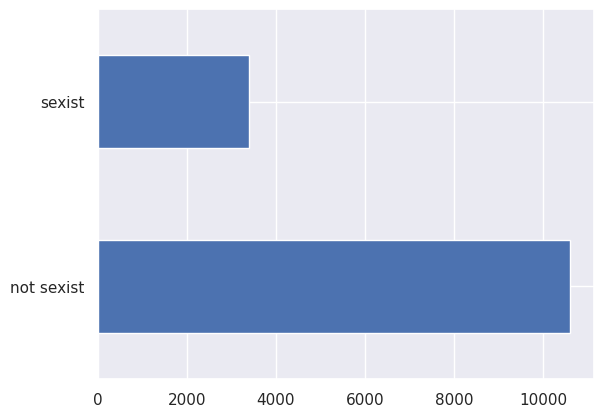

In [ ]:
df['label_sexist'].value_counts().plot.barh()

<Axes: >

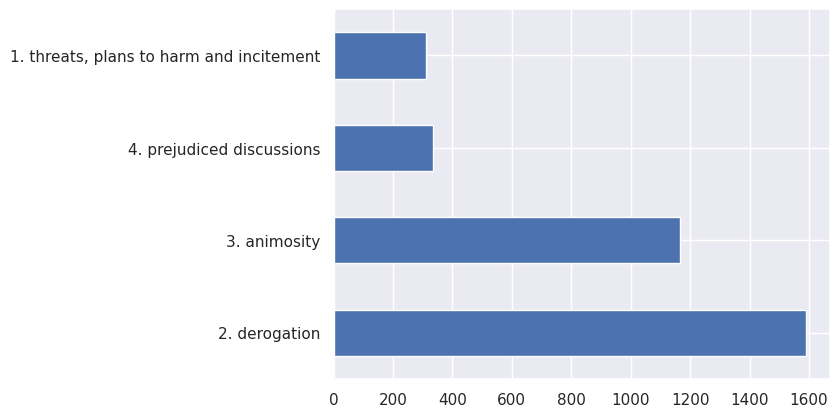

In [ ]:
df[df['label_sexist'] == 'sexist']['label_category'].value_counts().plot.barh()

<Axes: >

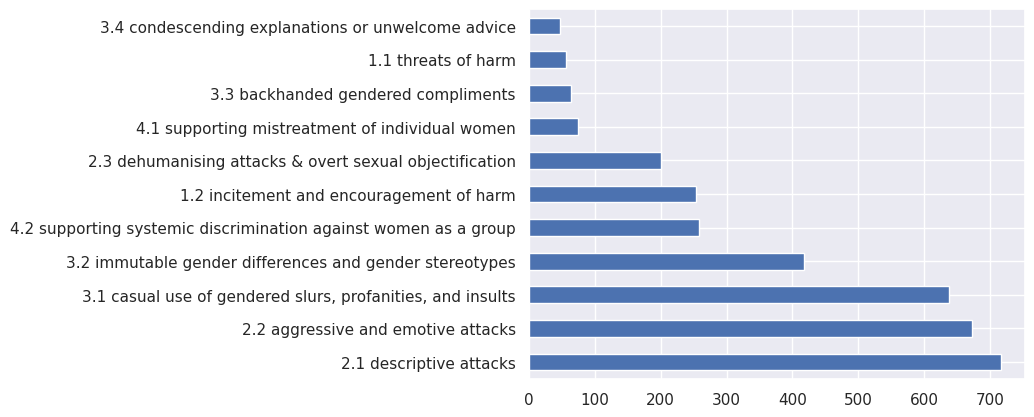

In [ ]:
df[df['label_sexist'] == 'sexist']['label_vector'].value_counts().plot.barh()

## Final Metrics Dictionary

In [ ]:
#Load updated metrics_dict
!gdown 12-x9NNmBrHEFsk7XDjL513V_Ey3uzEUQ

with open('/content/metrics_dict.pkl', 'rb') as f:
    metrics_dict = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=12-x9NNmBrHEFsk7XDjL513V_Ey3uzEUQ
To: /content/metrics_dict.pkl
100% 2.69k/2.69k [00:00<00:00, 5.47MB/s]


In [ ]:
metrics_dict['Task C']['advanced']['augmentation']

{'lstm': {'accuracy': 32.2, 'f1 score': 0.1},
 'berttiny': {'accuracy': 35.22, 'f1 score': 0.19},
 'distilroberta': {'accuracy': 46.7, 'f1 score': 0.35},
 'hateBERT_lr': {'accuracy': 50.47, 'f1 score': 0.34},
 'roberta_pretrained_lr': {'accuracy': 48.02, 'f1 score': 0.38}}

## Initial Choices


- Since we were provided a unique dataset we decided to split it into 3 parts: **70% Training Set, 15% Validation Set and 15% Test Set**
- `BATCH_SIZE` represents the maximum value we are able to store in the gpu

#🟢 [Task A] Simple Binary Classification: Sexist - No Sexist

In [ ]:
CLASSES = 2


## [A.1] Baseline Models

As a first step we are going to look at very simple models that will serve as a baseline and help us understand whether everything is working properly. Then we will take the best of these and apply regularization techniques to it (e.g. pretrained model on a similar task, weigth loss, learning rate scheduler and data augmentation).

In our case we will consider 3 different baselines:

- A simple **LSTM network**
- **TinyBert**
- **DistilRoberta**

### [A.1.1] LSTM with Glove Embedding
The first thing to do is to use a **simple neural network** to see how it will perform. We chose to consider a very simple neural network with an LSTM layer. This code snippet was repurposed from those websites: [Colab Notebook - AmarSaini](https://colab.research.google.com/github/AmarSaini/Epoching-Blog/blob/master/_notebooks/2021-06-27-NLP-from-Scratch-with-PyTorch-FastAI-and-HuggingFace.ipynb) and [Deep Learning Wizard](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/)

The final results are the following:
- Accuracy: [78.43%]
- F1 Score: [0.68]

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

#### Split Data



In [ ]:
#Here we want to keep the dataframe structure

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text'], x_test, df_train['label_sexist'], y_test = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state = 42)
df_test['text'], df_val['text'], df_test['label_sexist'], df_val['label_sexist'] = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

In [ ]:
df_train.head()

,text,label_sexist
12959,You'll want to stay away from Shelly. She stal...,not sexist
5502,[USER] hmmm so they just continuously suck goo...,not sexist
5890,I am a USMC daughter of the Korean war. I know...,not sexist
323,You should sing casually. Very good cope my fr...,not sexist
1344,"""if you think you have what it takes to lock m...",not sexist


#### Embedding Phase

In [ ]:
#We'll use the basic_english tokenizer in the torchtext library
tokenizer = get_tokenizer("basic_english")

In [ ]:
#Construct the vocabulary using the previous tokenizer

def build_vocabulary(dataset):
      for text in dataset:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary(df_train['text']), min_freq = 1, specials=["<UNK>", "<PAD>"])
vocab.set_default_index(0)

print(f'The vocabulary contains {len(vocab.get_itos())} tokens')

The vocabulary contains 19692 tokens


In [ ]:
#Let's import GloVe twitter.27B with dimension 50

glove = GloVe(name='twitter.27B', dim=50)
glove.vectors.shape

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:45, 5.33MB/s]                            
100%|█████████▉| 1193513/1193514 [00:31<00:00, 37896.72it/s]


torch.Size([1193514, 50])

In [ ]:
#Let's plug our previous vocabulary with the glove vocabulary
#Note that the OOV words are handled with a zero vector

vocab.vectors = glove.get_vecs_by_tokens(vocab.get_itos())
vocab.vectors.shape

torch.Size([19692, 50])

In [ ]:
train_dataset = SimpleDataset(df_train['text'], df_train['label_sexist'], vocab, tokenizer, MAX_LEN)
val_dataset = SimpleDataset(df_val['text'], df_val['label_sexist'], vocab, tokenizer, MAX_LEN)
test_dataset = SimpleDataset(df_val['text'], df_val['label_sexist'], vocab, tokenizer, MAX_LEN)

print(f'There are {len(train_dataset)} element in the training set')
print(f'There are {len(val_dataset)} element in the training set')
print(f'There are {len(test_dataset)} element in the training set')

There are 9800 element in the training set
There are 2100 element in the training set
There are 2100 element in the training set


In [ ]:
#Create the two dataloader

train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, VAL_BATCH_SIZE)

#### Model

In [ ]:
class LSTMBaseline(nn.Module):
    def __init__(self, vocab, hidden_dim, layer_dim, output_dim):
        super(LSTMBaseline, self).__init__()

        vocab_size, emb_size = vocab.vectors.shape
        
        self.emb = nn.Embedding(vocab_size, emb_size, _weight = vocab.vectors)

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(emb_size, hidden_dim, layer_dim, batch_first = True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        token_embs = self.emb(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        outputs, (h_n, c_n) = self.lstm(token_embs, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        outputs = self.fc(outputs[:, -1, :]) 
        # out.size() --> 100, 10
        return outputs

In [ ]:
model = LSTMBaseline(vocab, 256, 1, 2).to(device)

#### Train

In [ ]:
lr = 1e-4
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3,  min_delta = 0)

history = LSTM_training_loop(num_epochs, optimizer, log_interval,
                            model, train_dataloader, val_dataloader,
                            loss_func, early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.5578] - Val = [0.5518]  Accuracy: Train = [75.34%] - Val = [75.33%]  Time one epoch (s): 81.6514 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.5223] - Val = [0.4981]  Accuracy: Train = [75.81%] - Val = [76.62%]  Time one epoch (s): 87.5757 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.4743] - Val = [0.5196]  Accuracy: Train = [77.89%] - Val = [77.67%]  Time one epoch (s): 82.7957 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.4498] - Val = [0.4636]  Accuracy: Train = [79.94%] - Val = [78.90%]  Time one epoch (s): 84.7713 
Epoch: 5  Lr: 0.00010000  Loss: Train = [0.4281] - Val = [0.4573]  Accuracy: Train = [81.47%] - Val = [80.14%]  Time one epoch (s): 85.0758 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.4005] - Val = [0.4377]  Accuracy: Train = [82.93%] - Val = [79.90%]  Time one epoch (s): 83.7258 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.3755] - Val = [0.4380]  Accuracy: Train = [83.72%] - Val = [81.29%]  Time one epoch (s): 85.6098 
Epoch: 8  Lr:

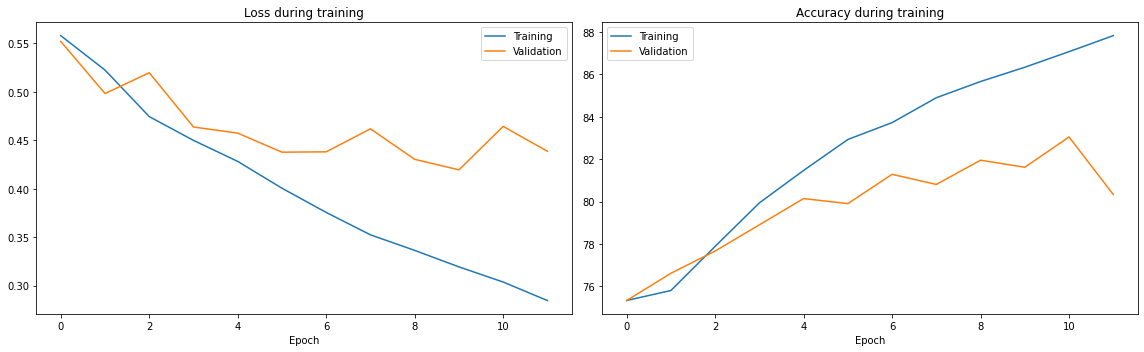

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/baseline/lstm/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation



In [ ]:
grand_truth, predictions = simple_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['baseline']['lstm'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                              'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['baseline']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['baseline']['lstm']['f1 score']}]")

Accuracy: [78.43%]
F1 Score: [0.68]


### [A.1.2] BERTTiny

As expected BERTTiny performs better. To be specific, we have an **accuracy of 79.24%** and **F1 Score equal to 0.73** on the test set.


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=2048,val_bs=2048,test_bs=2048,
                                                                             class_num=CLASSES,
                                                                             model_name='prajjwal1/bert-tiny',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-4
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.6648] - Val = [0.6142]  Accuracy: Train = [63.43%] - Val = [74.19%]  Time one epoch (s): 4.8041 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.5967] - Val = [0.5870]  Accuracy: Train = [76.03%] - Val = [74.19%]  Time one epoch (s): 4.6937 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.5713] - Val = [0.5742]  Accuracy: Train = [76.04%] - Val = [74.19%]  Time one epoch (s): 6.8037 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.5567] - Val = [0.5711]  Accuracy: Train = [76.04%] - Val = [74.19%]  Time one epoch (s): 4.6391 
Epoch: 5  Lr: 0.00010000  Loss: Train = [0.5525] - Val = [0.5716]  Accuracy: Train = [76.04%] - Val = [74.19%]  Time one epoch (s): 4.6209 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.5512] - Val = [0.5714]  Accuracy: Train = [76.04%] - Val = [74.19%]  Time one epoch (s): 7.0049 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.5493] - Val = [0.5694]  Accuracy: Train = [76.04%] - Val = [74.19%]  Time one epoch (s): 4.6374 
Epoch: 8  Lr: 0.0001

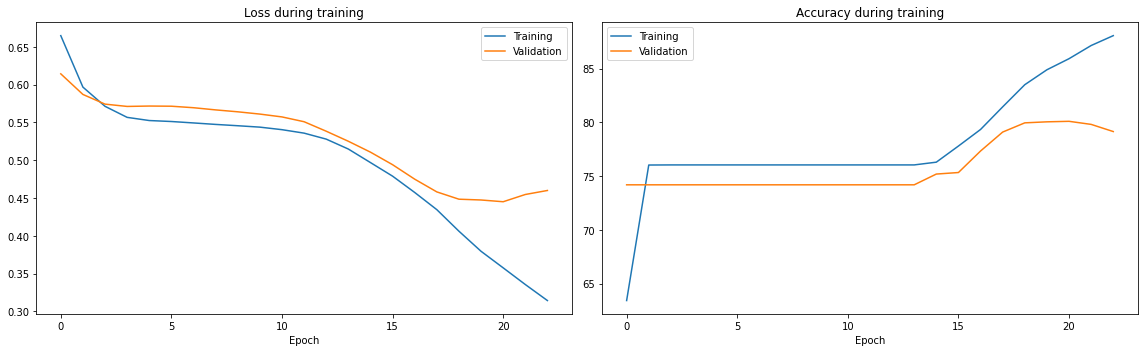

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/baseline/berttiny/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['baseline']['berttiny'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                  'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['baseline']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['baseline']['berttiny']['f1 score']}]")

Accuracy: [79.24%]
F1 Score: [0.73]


### [A.1.3] DistilRoBERTa

Finally DistilRoBERTa perform better than BERTTiny obtaining a good **83.0% accuracy** and **F1 Score equal to 0.78** in the test set.


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [0.5893] - Val = [0.5400]  Accuracy: Train = [71.46%] - Val = [75.62%]  Time one epoch (s): 41.6292 
Epoch: 2  Lr: 0.00001000  Loss: Train = [0.4917] - Val = [0.4449]  Accuracy: Train = [76.85%] - Val = [79.29%]  Time one epoch (s): 40.7390 
Epoch: 3  Lr: 0.00001000  Loss: Train = [0.3888] - Val = [0.3579]  Accuracy: Train = [82.83%] - Val = [84.29%]  Time one epoch (s): 41.3016 
Epoch: 4  Lr: 0.00001000  Loss: Train = [0.3283] - Val = [0.3707]  Accuracy: Train = [85.95%] - Val = [84.67%]  Time one epoch (s): 40.8391 
Epoch: 5  Lr: 0.00001000  Loss: Train = [0.2992] - Val = [0.3918]  Accuracy: Train = [87.14%] - Val = [81.57%]  Time one epoch (s): 40.8562 
Epoch: 6  Lr: 0.00001000  Loss: Train = [0.2727] - Val = [0.3447]  Accuracy: Train = [88.62%] - Val = [85.19%]  Time one epoch (s): 41.2213 
Epoch: 7  Lr: 0.00001000  Loss: Train = [0.2441] - Val = [0.3664]  Accuracy: Train = [90.15%] - Val = [83.81%]  Time one epoch (s): 40.8525 
Epoch: 8  Lr:

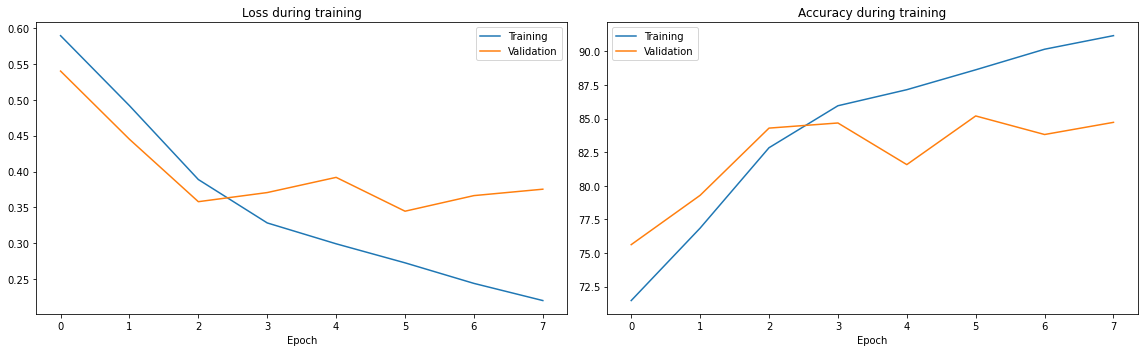

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/baseline/distilroberta/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['baseline']['distilroberta'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['baseline']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['baseline']['distilroberta']['f1 score']}]")

Accuracy: [83.0%]
F1 Score: [0.78]


### Models Comparison

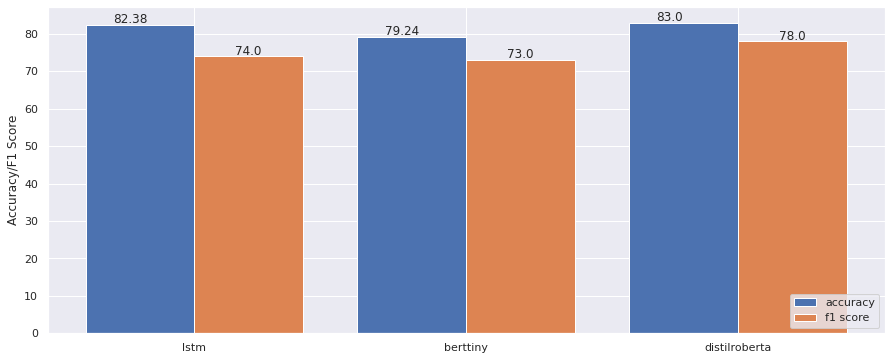

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task A']['baseline'].keys())
accuracies = [metrics_dict['Task A']['baseline'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task A']['baseline'][m]['f1 score'] for m in models]
f1_scores = [100 * f for f in f1_scores]


X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

## [A.2] Advanced

In order to improve the performance of the task we decided to:
- use pre-trained model on similar tasks
- apply regularization techniques:
  - Hyperparameter tuning (e.g. learning rate and optimizers)
  - Learning rate scheduling (e.g. StepLR, ReduceOnPlateau, OneCycleLR)
  - Data augmentation
  - Weight loss (omitted due to the poor performances)

After several trial (that we omitted in the notebook) we reached the best perfomance with the combination of **Adam** as optimizer and **OneCycleLR** as learning scheduler.

### [A.2.1] DistilRoBERTa with LR scheduler (OneCycleLR)

Since the best baseline model is DistilRoBERTa, we decided to apply learning rate scheduling to improve the performance of the model.

An overall improvement was achieved, in particular the **accuracy increased from 83.0% to 84.52%** and the **f1 score from 0.78 to 0.80**.

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper,
                        scheduler=scheduler)

Epoch: 1  Lr: 0.00000407  Loss: Train = [0.5973] - Val = [0.5507]  Accuracy: Train = [75.77%] - Val = [76.19%]  Time one epoch (s): 41.8372 
Epoch: 2  Lr: 0.00000429  Loss: Train = [0.5490] - Val = [0.5353]  Accuracy: Train = [76.08%] - Val = [76.19%]  Time one epoch (s): 41.5757 
Epoch: 3  Lr: 0.00000464  Loss: Train = [0.5245] - Val = [0.4940]  Accuracy: Train = [76.08%] - Val = [76.19%]  Time one epoch (s): 40.9273 
Epoch: 4  Lr: 0.00000514  Loss: Train = [0.4679] - Val = [0.4308]  Accuracy: Train = [77.16%] - Val = [79.76%]  Time one epoch (s): 41.0076 
Epoch: 5  Lr: 0.00000578  Loss: Train = [0.4122] - Val = [0.3741]  Accuracy: Train = [80.85%] - Val = [83.29%]  Time one epoch (s): 41.3168 
Epoch: 6  Lr: 0.00000656  Loss: Train = [0.3628] - Val = [0.3427]  Accuracy: Train = [84.30%] - Val = [85.14%]  Time one epoch (s): 40.9463 
Epoch: 7  Lr: 0.00000747  Loss: Train = [0.3287] - Val = [0.3352]  Accuracy: Train = [85.95%] - Val = [84.90%]  Time one epoch (s): 41.2966 
Epoch: 8  Lr:

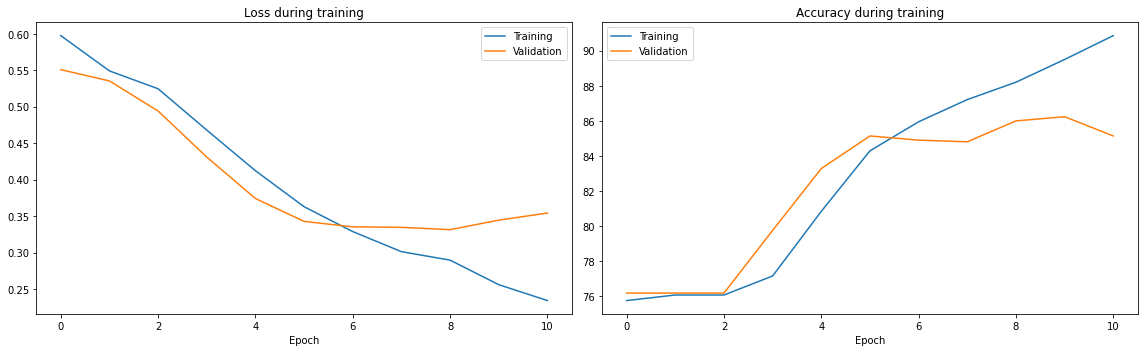

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/distilroberta_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['advanced']['distilroberta_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['distilroberta_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['distilroberta_lr']['f1 score']}]")

Accuracy: [84.52%]
F1 Score: [0.8]


### [A.2.2] RoBERTa pretrained on Hate Speech Dataset

We considered a pretrained RoBERTa model on a similar task: **TweetEval for Hate Speech Detection** ([twitter-roberta-base-hate](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate))

> hateBERT is a specialized dataset for classifying hate speech against women and immigrants

**Accuracy increased from 83.0 to 87.81 while f1 score from 0.78 to 0.83** cosidering the baseline DistilRoBERTa.



In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=64,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [0.4021] - Val = [0.3429]  Accuracy: Train = [82.40%] - Val = [84.52%]  Time one epoch (s): 81.0849 
Epoch: 2  Lr: 0.00001000  Loss: Train = [0.3231] - Val = [0.3138]  Accuracy: Train = [86.49%] - Val = [86.95%]  Time one epoch (s): 80.0907 
Epoch: 3  Lr: 0.00001000  Loss: Train = [0.2823] - Val = [0.3230]  Accuracy: Train = [88.58%] - Val = [86.10%]  Time one epoch (s): 80.6337 
Epoch: 4  Lr: 0.00001000  Loss: Train = [0.2519] - Val = [0.3161]  Accuracy: Train = [89.63%] - Val = [86.48%]  Time one epoch (s): 80.1074 
--- Early Stopping ---
Time for 4 epochs (s): 403.027


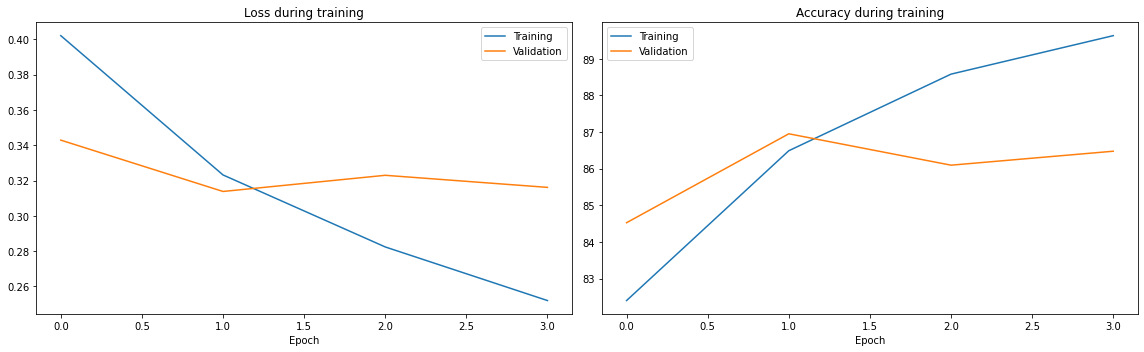

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/roberta_pretrained/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['advanced']['roberta_pretrained'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                            'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['roberta_pretrained']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['roberta_pretrained']['f1 score']}]")

Accuracy: [87.81%]
F1 Score: [0.83]


### [A.2.3] RoBERTa pretrained on Hate Speech Dataset with LR scheduler (OneCycleLR)

Since the previous model performed well on the task we tried to enhance the performance by adding a learning rate scheduler.

Unfortunatelly even if we tried to apply different scheduling techniques (ReduceOnPlateau, OneCycle, StepLr), the performance decreased by about one percentage point for both **accuracy** and **F1 score**.

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=64,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler = scheduler)

Epoch: 1  Lr: 0.00000407  Loss: Train = [0.4298] - Val = [0.3581]  Accuracy: Train = [81.00%] - Val = [85.14%]  Time one epoch (s): 80.6276 
Epoch: 2  Lr: 0.00000429  Loss: Train = [0.3721] - Val = [0.3225]  Accuracy: Train = [83.85%] - Val = [86.57%]  Time one epoch (s): 80.6818 
Epoch: 3  Lr: 0.00000464  Loss: Train = [0.3346] - Val = [0.3070]  Accuracy: Train = [85.74%] - Val = [86.86%]  Time one epoch (s): 80.0956 
Epoch: 4  Lr: 0.00000514  Loss: Train = [0.3132] - Val = [0.3040]  Accuracy: Train = [87.22%] - Val = [86.81%]  Time one epoch (s): 80.5472 
Epoch: 5  Lr: 0.00000578  Loss: Train = [0.2865] - Val = [0.2981]  Accuracy: Train = [88.37%] - Val = [87.81%]  Time one epoch (s): 80.2777 
Epoch: 6  Lr: 0.00000656  Loss: Train = [0.2689] - Val = [0.2949]  Accuracy: Train = [89.29%] - Val = [87.90%]  Time one epoch (s): 80.6056 
Epoch: 7  Lr: 0.00000747  Loss: Train = [0.2472] - Val = [0.2999]  Accuracy: Train = [90.12%] - Val = [88.05%]  Time one epoch (s): 80.1090 
Epoch: 8  Lr:

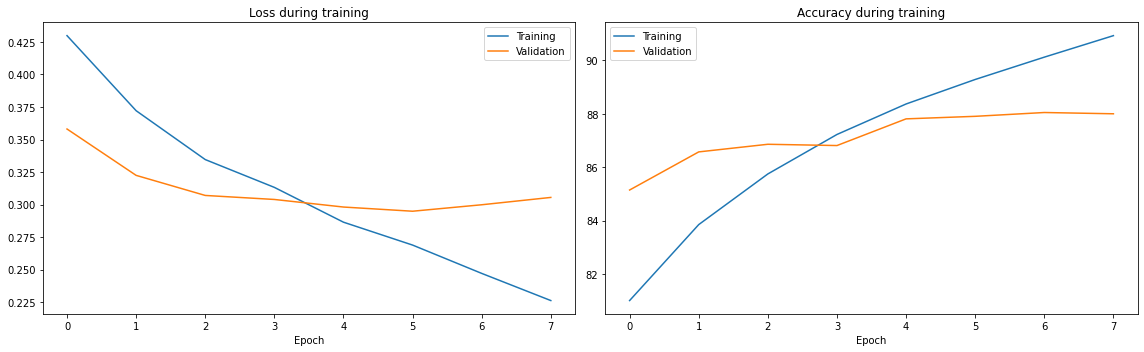

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/roberta_pretrained_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['advanced']['roberta_pretrained_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                               'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['roberta_pretrained_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['roberta_pretrained_lr']['f1 score']}]")

Accuracy: [86.9%]
F1 Score: [0.82]


### [A.2.4] HateBERT

We considered another model pretrained on a similar task: bert pretrained on a hate speech dataset ([hateBERT](https://huggingface.co/GroNLP/hateBERT)).

> HateBERT is an English pre-trained BERT model obtained by further training the English BERT base uncased model with more than 1 million posts from banned communites from Reddit.



The results are **similar to RoBERTa pretrained on TweetEval**.





In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=64,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [0.6145] - Val = [0.5295]  Accuracy: Train = [65.80%] - Val = [75.19%]  Time one epoch (s): 80.9255 
Epoch: 2  Lr: 0.00001000  Loss: Train = [0.5049] - Val = [0.4678]  Accuracy: Train = [75.98%] - Val = [78.52%]  Time one epoch (s): 80.1176 
Epoch: 3  Lr: 0.00001000  Loss: Train = [0.4221] - Val = [0.3706]  Accuracy: Train = [81.29%] - Val = [84.33%]  Time one epoch (s): 80.4819 
Epoch: 4  Lr: 0.00001000  Loss: Train = [0.3315] - Val = [0.3145]  Accuracy: Train = [86.52%] - Val = [86.81%]  Time one epoch (s): 79.8827 
Epoch: 5  Lr: 0.00001000  Loss: Train = [0.2635] - Val = [0.3090]  Accuracy: Train = [89.43%] - Val = [86.57%]  Time one epoch (s): 82.2619 
Epoch: 6  Lr: 0.00001000  Loss: Train = [0.2153] - Val = [0.3195]  Accuracy: Train = [91.76%] - Val = [87.00%]  Time one epoch (s): 80.1811 
Epoch: 7  Lr: 0.00001000  Loss: Train = [0.1824] - Val = [0.3273]  Accuracy: Train = [93.52%] - Val = [87.05%]  Time one epoch (s): 80.2954 
--- Early Sto

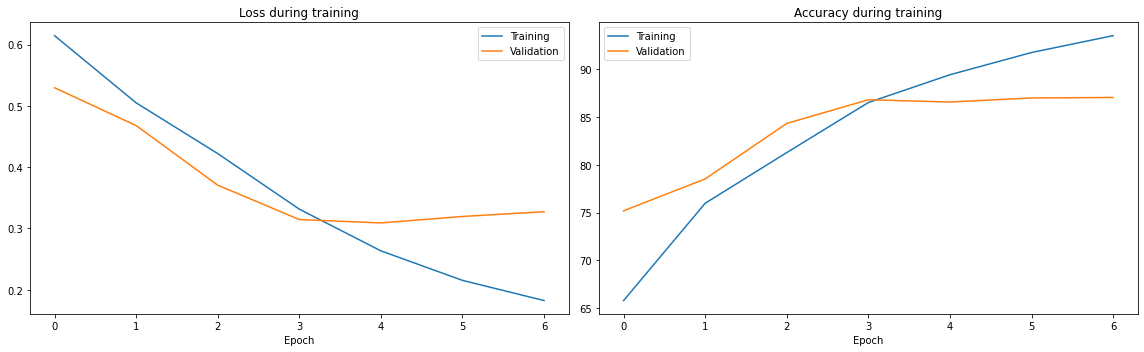

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/hateBERT/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['advanced']['hateBERT'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['hateBERT']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['hateBERT']['f1 score']}]")

Accuracy: [87.19%]
F1 Score: [0.82]


### [A.2.5] HateBERT with LR scheduler (OneCycleLR)

We have tried to implement the most effective learning scheduler techniques however **getting no improvement**.

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=64,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_sexist',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler=scheduler)

Epoch: 1  Lr: 0.00000407  Loss: Train = [0.6913] - Val = [0.5704]  Accuracy: Train = [52.98%] - Val = [75.48%]  Time one epoch (s): 82.0904 
Epoch: 2  Lr: 0.00000429  Loss: Train = [0.5495] - Val = [0.5379]  Accuracy: Train = [76.07%] - Val = [75.48%]  Time one epoch (s): 80.1923 
Epoch: 3  Lr: 0.00000464  Loss: Train = [0.5200] - Val = [0.5069]  Accuracy: Train = [76.05%] - Val = [75.48%]  Time one epoch (s): 80.8190 
Epoch: 4  Lr: 0.00000514  Loss: Train = [0.4847] - Val = [0.4697]  Accuracy: Train = [76.88%] - Val = [78.29%]  Time one epoch (s): 81.2946 
Epoch: 5  Lr: 0.00000578  Loss: Train = [0.4408] - Val = [0.4195]  Accuracy: Train = [79.51%] - Val = [80.67%]  Time one epoch (s): 80.7753 
Epoch: 6  Lr: 0.00000656  Loss: Train = [0.3821] - Val = [0.3680]  Accuracy: Train = [83.69%] - Val = [83.57%]  Time one epoch (s): 80.2454 
Epoch: 7  Lr: 0.00000747  Loss: Train = [0.3222] - Val = [0.3373]  Accuracy: Train = [87.01%] - Val = [85.43%]  Time one epoch (s): 80.2401 
Epoch: 8  Lr:

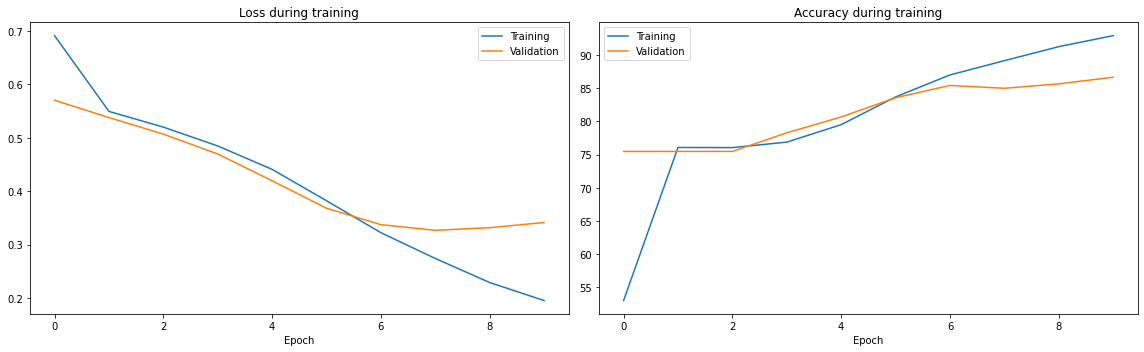

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/hateBERT_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task A']['advanced']['hateBERT_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['hateBERT_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['hateBERT_lr']['f1 score']}]")

Accuracy: [86.29%]
F1 Score: [0.82]


### [A.2.6] Data augmentation

In [ ]:
target_col = 'label_sexist'
aug_path = '/content/drive/MyDrive/NLP Project/Task A/advanced/augmentation/'

#### Generate the augmented training set

Augment the training set using Contextual Word Embeddings to generate similar words using popular models.

First we create the new training with `roberta-base`

In [ ]:
data_aug = DataAug('roberta-base','i',0.3)
data_aug.name +=  f"_{data_aug.augs[0].__dict__['model_type']}"

# Assess the quality of the new augmented samples
sexist_samples = df[df['label_sexist'] == 'sexist']['text'].iloc[:10].tolist()
data_aug.check_quality(sexist_samples)

df_train, df_val, df_test = split_data(df, True)

# Augment training set and save it
df_train_augmented = data_aug.augment(df_train)
data_aug.save_df(df_train_augmented)

print("Original\n")
print(df_train.groupby(['label_sexist'])['label_sexist'].value_counts())
print("\nAugmented\n")
df_train_augmented.groupby(['label_sexist'])['label_sexist'].value_counts()

,Original
0,"just the inside of your wallet: cash, bank cards, credit cards, debit cards. That is the inside that matters to femoids."
1,They get the initial chance because they are attractive. But women flock to them because they see other women flocking to them. Penguins hesitating to jump off the iceberg.
2,ugly chicks A pussy is a pussy.
3,fuck her off with a nine mm this is what you get when an arab fucks a monkey.
4,How about I talk shit to an idiot like you? Are you a nazi like that bitch?
5,If you want to attack culture and norms you have to go after the women themselves and call them out on their shit.
6,"Nah, black women still get more replies on tinder than even white men do. Their female privilege cancels out their black disadvantage."
7,dumb ass women today ask more why you are not divorced and collecting huge alimony checks
8,Men can be whores also.
9,Husbands. Kill your piece of shit commie wives


,Augmented
0,"just calculate the random inside contents of your wallet: cash, plastic bank report cards, credit cards, electric debit cards. That is the math inside that matters all to some femoids."
1,They will get only the initial cold chance because the they are merely attractive. 2 But women flock to them because they see other women just flocking naturally to them. Penguins quit hesitating to jump off into the local iceberg.
2,ugly old chicks Olivia A a pussy is a pussy.
3,fuck her hands off me with a good nine point mm this is what you get when calling an alien arab fucks you a monkey.
4,How much about I talk some shit to an idiot like fucking you? — Are you a nazi fuck like them that bitch?
5,If you do want to attack culture and norms you have got to fucking go up after women the working women themselves and call upon them straight out on their shit.
6,"Nah, many black trans women still apparently get more replies on digital tinder pens than even many white white men can do. Their female privilege literally cancels out their black disadvantage."
7,dumb ass Japanese women of today ask us more about why you are by not divorced up and collecting huge alimony checks
8,Men we can finally be whores – also.
9,Husbands. and Kill all your piece of baby shit commie and wives


Original

label_sexist  label_sexist
not sexist    not sexist      7451
sexist        sexist          2349
Name: label_sexist, dtype: int64

Augmented



label_sexist  label_sexist
not sexist    not sexist      14902
sexist        sexist           4698
Name: label_sexist, dtype: int64

Now we create a training set with `bert-base-cased`.
However after several trials, we noticed a little negative difference compared to the training set generated with `roberta-base`.

Therefore we decided to stick with the latter one for our tests.

In [ ]:
data_aug = DataAug('bert-base-cased','i',0.3)
data_aug.name +=  f"_{data_aug.augs[0].__dict__['model_type']}"

sexist_samples = df[df['label_sexist'] == 'sexist']['text'].iloc[:10].tolist()
data_aug.check_quality(sexist_samples)

df_train, df_val, df_test = split_data(df, True)

df_train_augmented = data_aug.augment(df_train)
data_aug.save_df(df_train_augmented)

,Original
0,"just the inside of your wallet: cash, bank cards, credit cards, debit cards. That is the inside that matters to femoids."
1,They get the initial chance because they are attractive. But women flock to them because they see other women flocking to them. Penguins hesitating to jump off the iceberg.
2,ugly chicks A pussy is a pussy.
3,fuck her off with a nine mm this is what you get when an arab fucks a monkey.
4,How about I talk shit to an idiot like you? Are you a nazi like that bitch?
5,If you want to attack culture and norms you have to go after the women themselves and call them out on their shit.
6,"Nah, black women still get more replies on tinder than even white men do. Their female privilege cancels out their black disadvantage."
7,dumb ass women today ask more why you are not divorced and collecting huge alimony checks
8,Men can be whores also.
9,Husbands. Kill your piece of shit commie wives


,Augmented
0,"Name just the inside of your your wallet : cash, bank cards, even credit cards, no debit transaction cards. com That envelope is the inside that matters more to any femoids."
1,9 They get the initial chance because they are very attractive. But young women flock to them because they see such other wild women in flocking out to claim them. Swamp Penguins hesitating as to jump off the frozen iceberg.
2,ugly sticky chicks indeed A pussy star is only a pussy.
3,fuck her off the with ever a single nine mm this is what fuck you get off when an arab fucks apart a giant monkey.
4,« How about I can talk shit to like an idiot there like... you? Are you a damn nazi like that bitch?
5,If you want us to simultaneously attack culture and ethnic norms you have order to go after the women fuck themselves... and call them out on you their living shit.
6,"1 Nah, black Southern women still get more ambiguous replies riding on tinder wheels than nearly even white men do. Their black female privilege basically cancels us out their black disadvantage."
7,dumb ass women here today ask more about why you too are actually not divorced... and still collecting huge alimony checks
8,Men you can often be filthy whores also.
9,Husbands. Kill over your piece because of my shit commie for wives


#### Baseline

LSTM model

In [ ]:
df_train = load_aug_train('/content/drive/MyDrive/NLP Project/Augmented_trainings/ContextualWordEmbs_Aug_insert_3_roberta.csv',True)
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 'LSTM', 8)

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.5476] - Val = [0.5047]  Accuracy: Train = [76.00%] - Val = [74.81%]  Time one epoch (s): 36.8827 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.4801] - Val = [0.4775]  Accuracy: Train = [77.94%] - Val = [79.10%]  Time one epoch (s): 35.2414 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.4242] - Val = [0.4357]  Accuracy: Train = [81.63%] - Val = [80.76%]  Time one epoch (s): 34.9723 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.3815] - Val = [0.4470]  Accuracy: Train = [83.71%] - Val = [78.95%]  Time one epoch (s): 34.5050 
Epoch: 5  Lr: 0.00010000  Loss: Train = [0.3506] - Val = [0.4369]  Accuracy: Train = [85.22%] - Val = [80.76%]  Time one epoch (s): 35.4418 
--- Early Stopping ---
Time for 5 epochs (s): 212.172


In [ ]:
ground_truth, predictions = simple_return_values(model, dataloaders['test'])
metrics_dict['Task A']['advanced']['augmentation']['lstm'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                              'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['augmentation']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['augmentation']['lstm']['f1 score']}]")

Accuracy: [81.57%]
F1 Score: [0.74]


In [ ]:
model_weights_path = os.path.join(aug_path,'lstm/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

BERTTiny model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'prajjwal1/bert-tiny', 2048)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.4375] - Val = [0.3990]  Accuracy: Train = [81.18%] - Val = [82.57%]  Time one epoch (s): 66.8662 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.3053] - Val = [0.4598]  Accuracy: Train = [87.20%] - Val = [80.95%]  Time one epoch (s): 66.8373 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.2009] - Val = [0.5846]  Accuracy: Train = [91.89%] - Val = [80.67%]  Time one epoch (s): 67.1393 
--- Early Stopping ---
Time for 3 epochs (s): 267.701


In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task A']['advanced']['augmentation']['berttiny'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                  'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['augmentation']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['augmentation']['berttiny']['f1 score']}]")

Accuracy: [81.05%]
F1 Score: [0.73]


In [ ]:
model_weights_path = os.path.join(aug_path,'berttiny/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

DistilRoBERTa model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'distilroberta-base', 256)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.4457] - Val = [0.3638]  Accuracy: Train = [80.39%] - Val = [84.62%]  Time one epoch (s): 81.5460 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.2709] - Val = [0.4417]  Accuracy: Train = [89.07%] - Val = [84.43%]  Time one epoch (s): 83.8359 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.1515] - Val = [0.4886]  Accuracy: Train = [94.37%] - Val = [84.19%]  Time one epoch (s): 79.4640 
--- Early Stopping ---
Time for 3 epochs (s): 322.750


In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task A']['advanced']['augmentation']['distilroberta'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                       'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['augmentation']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['augmentation']['distilroberta']['f1 score']}]")

Accuracy: [84.95%]
F1 Score: [0.78]


In [ ]:
model_weights_path = os.path.join(aug_path,'distilroberta/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

#### Best model

In [ ]:
df_train, df_val, df_test = split_data(df, True)
df_train = load_aug_train('/content/drive/MyDrive/NLP Project/Augmented_trainings/ContextualWordEmbs_Aug_insert_3_roberta.csv',True)
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'cardiffnlp/twitter-roberta-base-hate', 256,
                                                use_scheduler=True)

Epoch: 1  Lr: 0.00000402  Loss: Train = [0.4090] - Val = [0.3932]  Accuracy: Train = [82.35%] - Val = [82.14%]  Time one epoch (s): 153.3123 
Epoch: 2  Lr: 0.00000407  Loss: Train = [0.3374] - Val = [0.3693]  Accuracy: Train = [86.10%] - Val = [84.24%]  Time one epoch (s): 154.6077 
Epoch: 3  Lr: 0.00000416  Loss: Train = [0.3037] - Val = [0.3636]  Accuracy: Train = [87.69%] - Val = [85.38%]  Time one epoch (s): 153.3183 
Epoch: 4  Lr: 0.00000429  Loss: Train = [0.2751] - Val = [0.3587]  Accuracy: Train = [88.99%] - Val = [85.48%]  Time one epoch (s): 153.8273 
Epoch: 5  Lr: 0.00000445  Loss: Train = [0.2482] - Val = [0.3765]  Accuracy: Train = [90.21%] - Val = [84.95%]  Time one epoch (s): 153.2071 
Epoch: 6  Lr: 0.00000465  Loss: Train = [0.2228] - Val = [0.3866]  Accuracy: Train = [91.60%] - Val = [85.38%]  Time one epoch (s): 154.0401 
--- Early Stopping ---
Time for 6 epochs (s): 1075.638


In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task A']['advanced']['augmentation']['roberta_pretrained_lr'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                               'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task A']['advanced']['augmentation']['roberta_pretrained_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task A']['advanced']['augmentation']['roberta_pretrained_lr']['f1 score']}]")

Accuracy: [86.14%]
F1 Score: [0.82]


In [ ]:
model_weights_path = os.path.join(aug_path,'roberta_pretrained_lr/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# Save results
with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Models Comparison

#### Scheduler

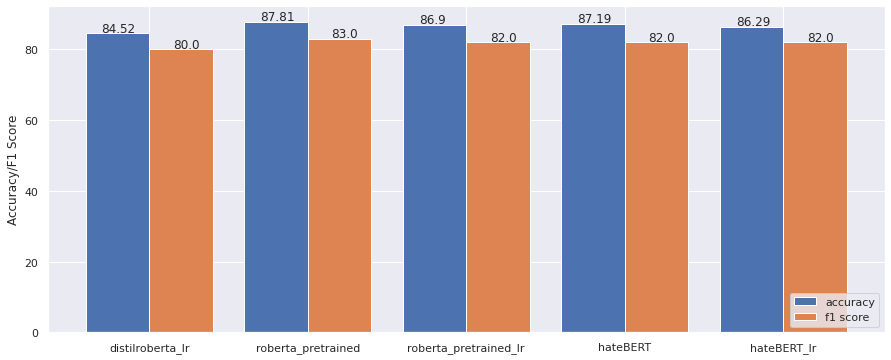

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task A']['advanced'].keys())
accuracies = [metrics_dict['Task A']['advanced'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task A']['advanced'][m]['f1 score'] for m in models]
f1_scores = [100 * f for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

#### Data Augmentation
As we can see from the plot below for Task A with Data Augmentation the results remained unchanged with respect to the the baseline.

Same goes for the best model of Task A *Twitter-roBERTa-base* (`roberta_pretrained_lr`).

Suggesting that there is already enough data for the models to learn from

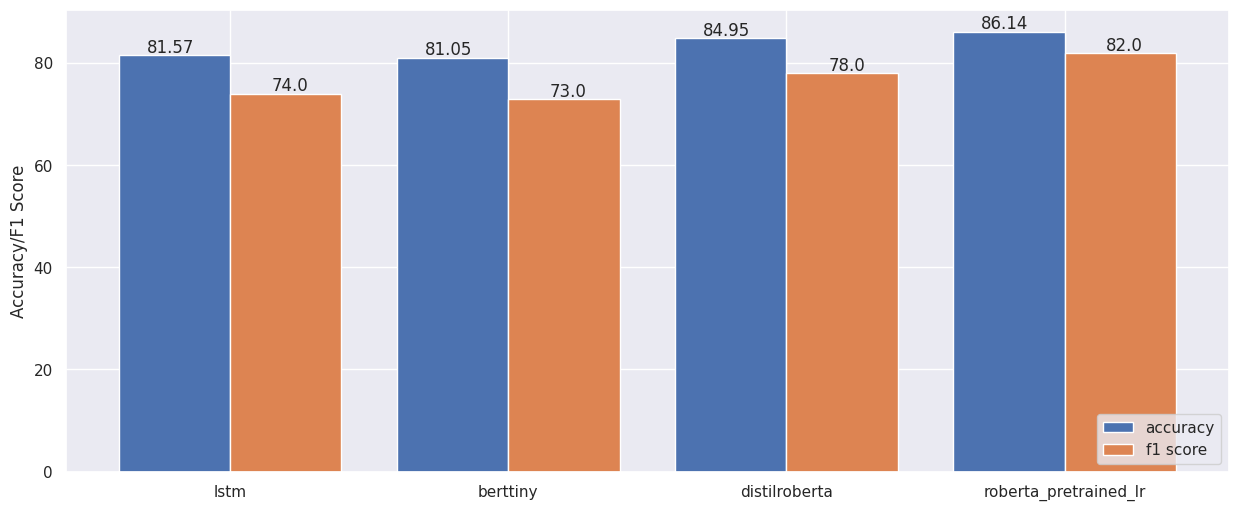

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task A']['advanced']['augmentation'].keys())
accuracies = [metrics_dict['Task A']['advanced']['augmentation'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task A']['advanced']['augmentation'][m]['f1 score'] for m in models]
f1_scores = [100 * f for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

# 🟢 [Task B] Sexist text classification


Since the dataset contained both sexist and not sexists sentences, for the task B we had to remove the non sexist phrases, so we had a relevant decrease of data (about the 75%)

In [ ]:
CLASSES = 4
df = df[df['label_sexist'] == "sexist"]
len(df)

3398

## [B.1] Baseline

We used the same baseline models of the task A, obtraining the following results:
- **LSTM**
  - Accuracy: [46.08%]
  - F1 Score: [0.16]
- **BERTTiny**
  - Accuracy: [46.76%]
  - F1 Score: [0.35]
- **DistilRoBERTa**
  - Accuracy: [57.56%]
  - F1 Score: [0.55]

### [B.1.1] LSTM with Glove Embedding

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

#### Split Data



In [ ]:
#Here we want to keep the dataframe structure

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text'], x_test, df_train['label_category'], y_test = train_test_split(df['text'], df['label_category'], test_size=0.3, random_state = 42)
df_test['text'], df_val['text'], df_test['label_category'], df_val['label_category'] = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

In [ ]:
df_train.head()

,text,label_category
4058,Kids make stupid mistakes like tie up mentally...,4. prejudiced discussions
1912,Read whereareallthegoodmen sub and stay away f...,2. derogation
7091,"Just keep practicing, is you get as good at it...",3. animosity
4391,hotter girls have higher bitch shields and shi...,3. animosity
11760,"Fuck you, you sanctimonious cunt.",3. animosity


#### Embedding Phase

In [ ]:
#We'll use the basic_english tokenizer in the torchtext library
tokenizer = get_tokenizer("basic_english")

In [ ]:
#Construct the vocabulary using the previous tokenizer

def build_vocabulary(dataset):
      for text in dataset:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary(df_train['text']), min_freq = 1, specials=["<UNK>", "<PAD>"])
vocab.set_default_index(0)

print(f'The vocabulary contains {len(vocab.get_itos())} tokens')

The vocabulary contains 7990 tokens


In [ ]:
#Let's import GloVe twitter.27B with dimension 50

glove = GloVe(name='twitter.27B', dim=50)
glove.vectors.shape

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [00:30<00:00, 39664.20it/s]


torch.Size([1193514, 50])

In [ ]:
#Let's plug our previous vocabulary with the glove vocabulary
#Note that the OOV words are handled with a zero vector

vocab.vectors = glove.get_vecs_by_tokens(vocab.get_itos())
vocab.vectors.shape

torch.Size([7990, 50])

In [ ]:
train_dataset = SimpleDataset(df_train['text'], df_train['label_category'], vocab, tokenizer, MAX_LEN)
val_dataset = SimpleDataset(df_val['text'], df_val['label_category'], vocab, tokenizer, MAX_LEN)
test_dataset = SimpleDataset(df_val['text'], df_val['label_category'], vocab, tokenizer, MAX_LEN)

print(f'There are {len(train_dataset)} element in the training set')
print(f'There are {len(val_dataset)} element in the training set')
print(f'There are {len(test_dataset)} element in the training set')

There are 2378 element in the training set
There are 510 element in the training set
There are 510 element in the training set


In [ ]:
#Create the two dataloader

train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, VAL_BATCH_SIZE)

#### Model

In [ ]:
class LSTMBaseline(nn.Module):
    def __init__(self, vocab, hidden_dim, layer_dim, output_dim):
        super(LSTMBaseline, self).__init__()

        vocab_size, emb_size = vocab.vectors.shape
        
        self.emb = nn.Embedding(vocab_size, emb_size, _weight = vocab.vectors)

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(emb_size, hidden_dim, layer_dim, batch_first = True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        token_embs = self.emb(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        outputs, (h_n, c_n) = self.lstm(token_embs, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        outputs = self.fc(outputs[:, -1, :]) 
        # out.size() --> 100, 10
        return outputs

In [ ]:
model = LSTMBaseline(vocab, 256, 1, CLASSES).to(device)

#### Train

In [ ]:
lr = 1e-4
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3,  min_delta = 0)

history = LSTM_training_loop(num_epochs, optimizer, log_interval,
                            model, train_dataloader, val_dataloader,
                            loss_func, early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.2281] - Val = [1.2080]  Accuracy: Train = [44.79%] - Val = [45.49%]  Time one epoch (s): 4.9817 
Epoch: 2  Lr: 0.00010000  Loss: Train = [1.1766] - Val = [1.1951]  Accuracy: Train = [46.13%] - Val = [45.88%]  Time one epoch (s): 4.1781 
Epoch: 3  Lr: 0.00010000  Loss: Train = [1.1763] - Val = [1.1991]  Accuracy: Train = [46.13%] - Val = [43.92%]  Time one epoch (s): 3.6226 
Epoch: 4  Lr: 0.00010000  Loss: Train = [1.1679] - Val = [1.2013]  Accuracy: Train = [46.17%] - Val = [43.73%]  Time one epoch (s): 3.5561 
--- Early Stopping ---
Time for 4 epochs (s): 20.391


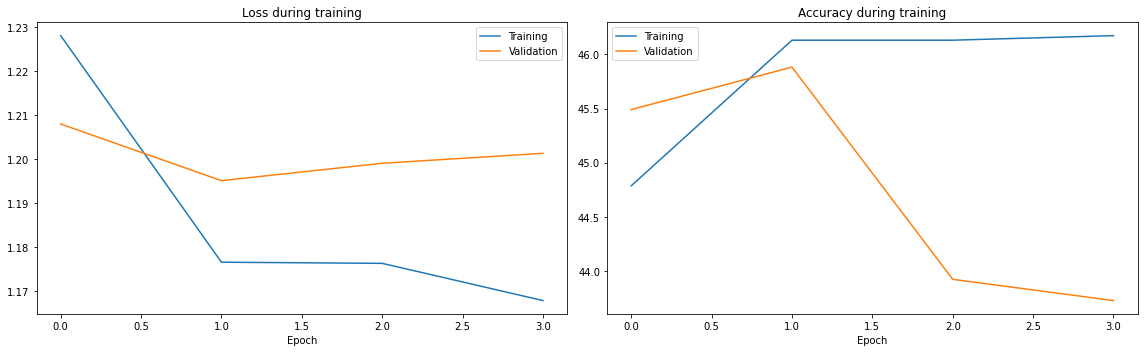

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/baseline/lstm/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation



In [ ]:
grand_truth, predictions = simple_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['baseline']['lstm'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                              'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['baseline']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['baseline']['lstm']['f1 score']}]")

Accuracy: [46.08%]
F1 Score: [0.16]


### [B.1.2] BERTTiny


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=2048,val_bs=2048,test_bs=2048,
                                                                             class_num=CLASSES,
                                                                             model_name='prajjwal1/bert-tiny',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-4
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.3929] - Val = [1.3381]  Accuracy: Train = [24.25%] - Val = [35.29%]  Time one epoch (s): 4.7756 
Epoch: 2  Lr: 0.00010000  Loss: Train = [1.3402] - Val = [1.3095]  Accuracy: Train = [37.03%] - Val = [32.94%]  Time one epoch (s): 2.4392 
Epoch: 3  Lr: 0.00010000  Loss: Train = [1.3070] - Val = [1.2873]  Accuracy: Train = [36.99%] - Val = [32.75%]  Time one epoch (s): 2.0601 
Epoch: 4  Lr: 0.00010000  Loss: Train = [1.2811] - Val = [1.2701]  Accuracy: Train = [35.48%] - Val = [32.55%]  Time one epoch (s): 2.1045 
Epoch: 5  Lr: 0.00010000  Loss: Train = [1.2605] - Val = [1.2540]  Accuracy: Train = [35.44%] - Val = [32.75%]  Time one epoch (s): 1.6629 
Epoch: 6  Lr: 0.00010000  Loss: Train = [1.2430] - Val = [1.2391]  Accuracy: Train = [37.28%] - Val = [33.53%]  Time one epoch (s): 1.6492 
Epoch: 7  Lr: 0.00010000  Loss: Train = [1.2274] - Val = [1.2252]  Accuracy: Train = [38.88%] - Val = [39.02%]  Time one epoch (s): 1.6688 
Epoch: 8  Lr: 0.0001

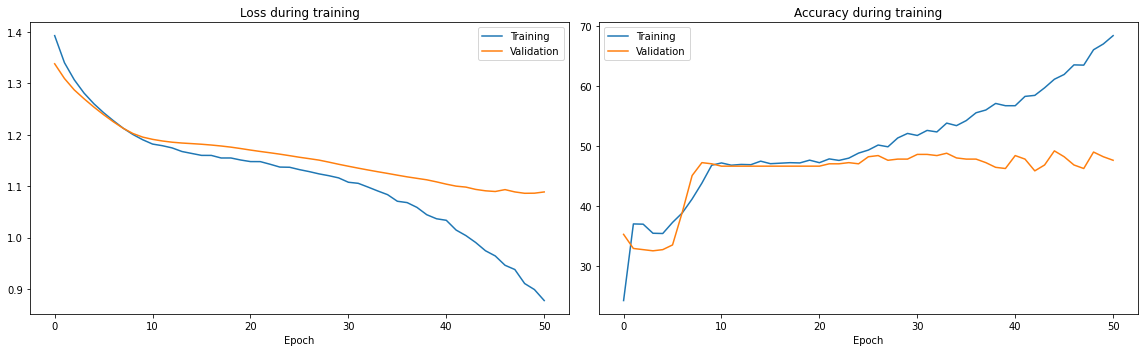

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/baseline/berttiny/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['baseline']['berttiny'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                  'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['baseline']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['baseline']['berttiny']['f1 score']}]")

Accuracy: [46.76%]
F1 Score: [0.35]


### [B.1.3] DistilRoBERTa


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [1.3997] - Val = [1.3253]  Accuracy: Train = [28.92%] - Val = [45.69%]  Time one epoch (s): 10.1230 
Epoch: 2  Lr: 0.00001000  Loss: Train = [1.2567] - Val = [1.1575]  Accuracy: Train = [47.54%] - Val = [45.69%]  Time one epoch (s): 10.1668 
Epoch: 3  Lr: 0.00001000  Loss: Train = [1.1725] - Val = [1.1173]  Accuracy: Train = [47.25%] - Val = [45.69%]  Time one epoch (s): 10.2254 
Epoch: 4  Lr: 0.00001000  Loss: Train = [1.1518] - Val = [1.1112]  Accuracy: Train = [46.91%] - Val = [45.69%]  Time one epoch (s): 10.2650 
Epoch: 5  Lr: 0.00001000  Loss: Train = [1.1265] - Val = [1.0669]  Accuracy: Train = [47.84%] - Val = [45.69%]  Time one epoch (s): 10.2808 
Epoch: 6  Lr: 0.00001000  Loss: Train = [1.0766] - Val = [1.0351]  Accuracy: Train = [48.55%] - Val = [44.51%]  Time one epoch (s): 10.4204 
Epoch: 7  Lr: 0.00001000  Loss: Train = [1.0154] - Val = [0.9872]  Accuracy: Train = [50.32%] - Val = [51.37%]  Time one epoch (s): 10.5703 
Epoch: 8  Lr:

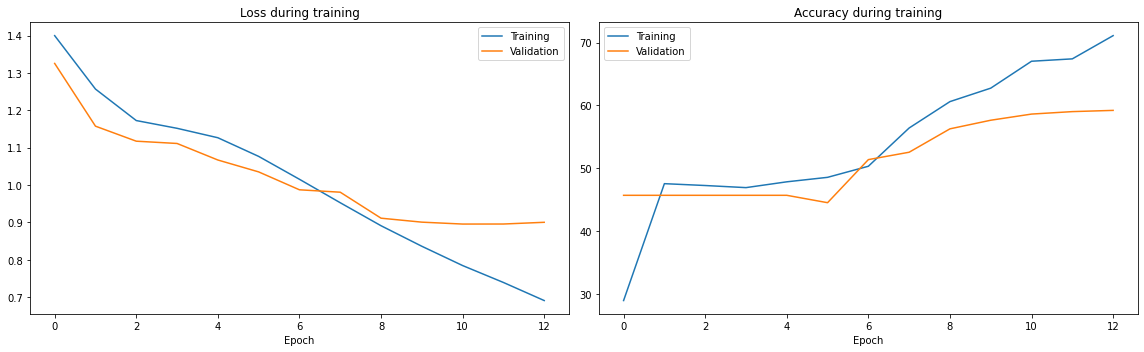

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/baseline/distilroberta/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['baseline']['distilroberta'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['baseline']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['baseline']['distilroberta']['f1 score']}]")

Accuracy: [57.56%]
F1 Score: [0.55]


### Models Comparison

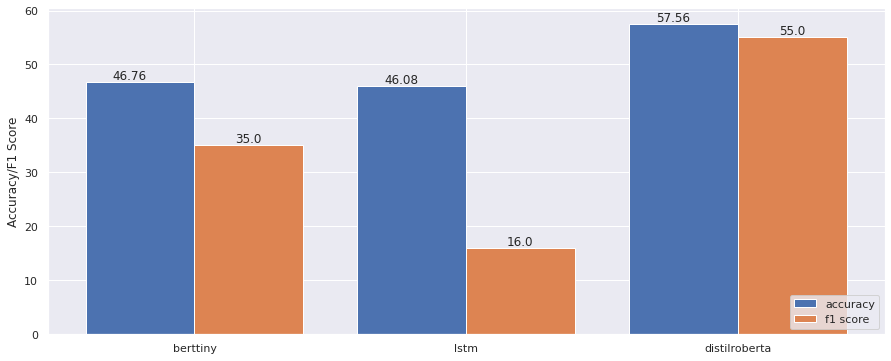

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task B']['baseline'].keys())
accuracies = [metrics_dict['Task B']['baseline'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task B']['baseline'][m]['f1 score'] for m in models]
f1_scores = [round(100 * f, 1) for f in f1_scores]


X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

## [B.2] Advanced

We also used the same advanced models of the task A, obtraining the following results:
- **DistilRoBERTa** with Learning scheduler (OneCycleLR)
  - Accuracy: [60.12%]
  - F1 Score: [0.56]
- **RoBERTa pretrained** on hate speech dataset
  - Accuracy: [63.26%]
  - F1 Score: [0.60]
- **RoBERTa pretrained** on hate speech dataset with Learning scheduler (OneCycleLR)
  - Accuracy: [63.06%]
  - F1 Score: [0.60]
- **hateBERT**
  - Accuracy: [61.49%]
  - F1 Score: [0.59]
- **hateBERT with Learning scheduler** (OneCycleLR)
  - Accuracy: [65.23%]
  - F1 Score: [0.62]

### [B.2.1] DistilRoBERTa with LR scheduling (OneCycleLR)


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper,
                        scheduler=scheduler)

Epoch: 1  Lr: 0.00000520  Loss: Train = [1.3767] - Val = [1.3447]  Accuracy: Train = [18.79%] - Val = [18.43%]  Time one epoch (s): 10.0148 
Epoch: 2  Lr: 0.00000875  Loss: Train = [1.3255] - Val = [1.2806]  Accuracy: Train = [36.07%] - Val = [49.02%]  Time one epoch (s): 9.7109 
Epoch: 3  Lr: 0.00001447  Loss: Train = [1.2451] - Val = [1.1595]  Accuracy: Train = [46.24%] - Val = [49.02%]  Time one epoch (s): 10.4087 
Epoch: 4  Lr: 0.00002207  Loss: Train = [1.1828] - Val = [1.1459]  Accuracy: Train = [46.91%] - Val = [49.02%]  Time one epoch (s): 11.9280 
Epoch: 5  Lr: 0.00003117  Loss: Train = [1.1680] - Val = [1.1257]  Accuracy: Train = [45.52%] - Val = [49.02%]  Time one epoch (s): 10.5438 
Epoch: 6  Lr: 0.00004132  Loss: Train = [1.1380] - Val = [1.0809]  Accuracy: Train = [46.95%] - Val = [49.41%]  Time one epoch (s): 10.6667 
Epoch: 7  Lr: 0.00005200  Loss: Train = [1.0496] - Val = [0.9663]  Accuracy: Train = [52.04%] - Val = [54.51%]  Time one epoch (s): 10.7852 
Epoch: 8  Lr: 

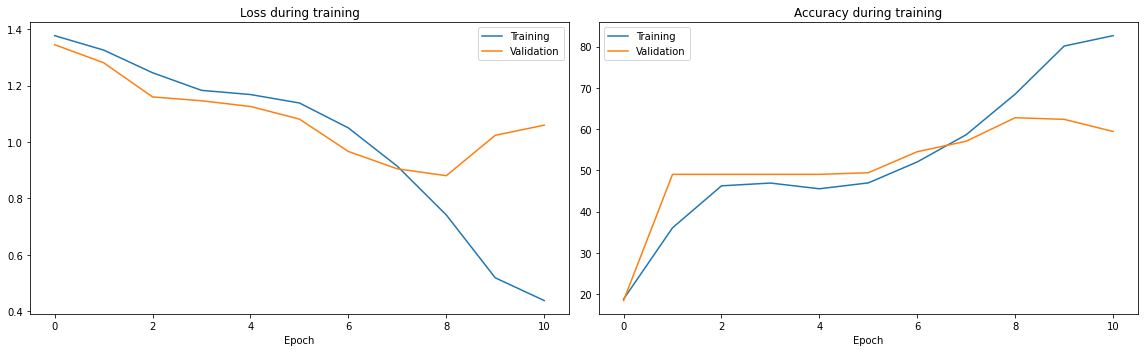

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/distilroberta_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['advanced']['distilroberta_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['distilroberta_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['distilroberta_lr']['f1 score']}]")

Accuracy: [60.12%]
F1 Score: [0.56]


### [B.2.2] RoBERTa pretrained on Hate Speech


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [1.2246] - Val = [1.1502]  Accuracy: Train = [42.45%] - Val = [50.78%]  Time one epoch (s): 26.4412 
Epoch: 2  Lr: 0.00001000  Loss: Train = [1.0841] - Val = [1.0574]  Accuracy: Train = [51.83%] - Val = [51.18%]  Time one epoch (s): 19.0677 
Epoch: 3  Lr: 0.00001000  Loss: Train = [0.9695] - Val = [0.9748]  Accuracy: Train = [57.21%] - Val = [57.25%]  Time one epoch (s): 19.6014 
Epoch: 4  Lr: 0.00001000  Loss: Train = [0.8483] - Val = [0.9439]  Accuracy: Train = [66.37%] - Val = [60.98%]  Time one epoch (s): 19.3246 
Epoch: 5  Lr: 0.00001000  Loss: Train = [0.7390] - Val = [0.9611]  Accuracy: Train = [70.28%] - Val = [60.78%]  Time one epoch (s): 20.6093 
Epoch: 6  Lr: 0.00001000  Loss: Train = [0.6345] - Val = [0.9419]  Accuracy: Train = [75.54%] - Val = [64.90%]  Time one epoch (s): 20.0081 
Epoch: 7  Lr: 0.00001000  Loss: Train = [0.5338] - Val = [0.9991]  Accuracy: Train = [81.13%] - Val = [64.51%]  Time one epoch (s): 19.7582 
Epoch: 8  Lr:

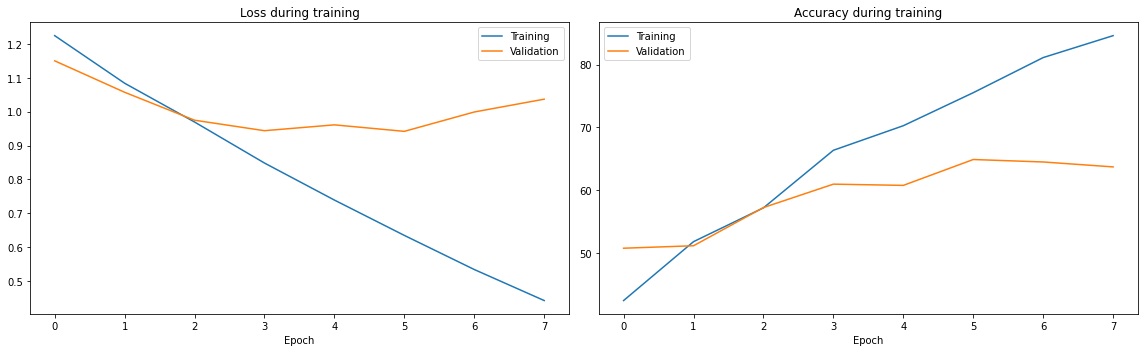

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/roberta_pretrained/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['advanced']['roberta_pretrained'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                  'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['roberta_pretrained']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['roberta_pretrained']['f1 score']}]")

Accuracy: [63.26%]
F1 Score: [0.6]


### [B.2.3] RoBERTa pretrained on Hate Speech Dataset with LR scheduler (OneCycleLR)

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler = scheduler)

Epoch: 1  Lr: 0.00000431  Loss: Train = [1.3233] - Val = [1.1925]  Accuracy: Train = [37.41%] - Val = [46.67%]  Time one epoch (s): 29.4854 
Epoch: 2  Lr: 0.00000525  Loss: Train = [1.1565] - Val = [1.1491]  Accuracy: Train = [47.37%] - Val = [46.47%]  Time one epoch (s): 21.0401 
Epoch: 3  Lr: 0.00000679  Loss: Train = [1.1097] - Val = [1.1206]  Accuracy: Train = [50.90%] - Val = [50.39%]  Time one epoch (s): 23.5236 
Epoch: 4  Lr: 0.00000892  Loss: Train = [1.0596] - Val = [1.0493]  Accuracy: Train = [53.01%] - Val = [51.57%]  Time one epoch (s): 21.3800 
Epoch: 5  Lr: 0.00001162  Loss: Train = [0.9655] - Val = [0.9838]  Accuracy: Train = [58.22%] - Val = [56.08%]  Time one epoch (s): 20.5261 
Epoch: 6  Lr: 0.00001484  Loss: Train = [0.8439] - Val = [0.9331]  Accuracy: Train = [66.08%] - Val = [61.57%]  Time one epoch (s): 23.2656 
Epoch: 7  Lr: 0.00001855  Loss: Train = [0.7093] - Val = [0.9717]  Accuracy: Train = [72.05%] - Val = [62.35%]  Time one epoch (s): 21.1551 
Epoch: 8  Lr:

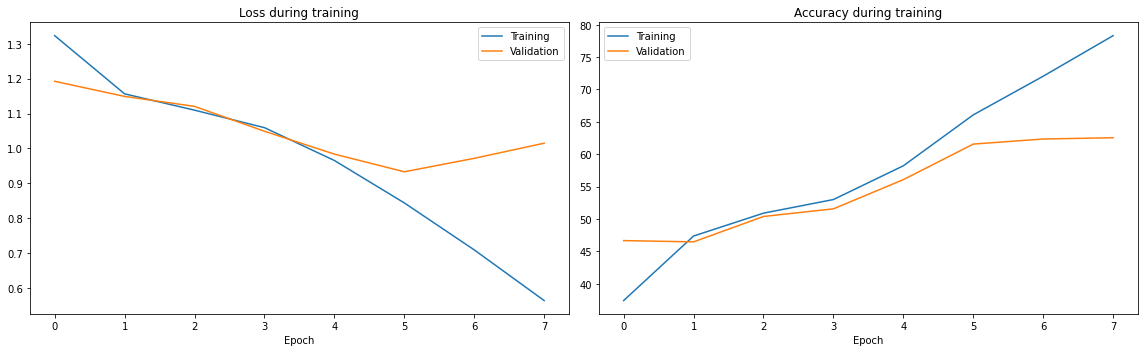

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/roberta_pretrained_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['advanced']['roberta_pretrained_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                               'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['roberta_pretrained_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['roberta_pretrained_lr']['f1 score']}]")

Accuracy: [63.06%]
F1 Score: [0.6]


### [B.2.4] HateBERT

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [1.3578] - Val = [1.1792]  Accuracy: Train = [33.46%] - Val = [43.14%]  Time one epoch (s): 20.3560 
Epoch: 2  Lr: 0.00001000  Loss: Train = [1.1579] - Val = [1.1350]  Accuracy: Train = [47.88%] - Val = [42.75%]  Time one epoch (s): 20.6365 
Epoch: 3  Lr: 0.00001000  Loss: Train = [1.1084] - Val = [1.0833]  Accuracy: Train = [49.47%] - Val = [45.88%]  Time one epoch (s): 20.7343 
Epoch: 4  Lr: 0.00001000  Loss: Train = [1.0531] - Val = [1.0473]  Accuracy: Train = [52.50%] - Val = [48.04%]  Time one epoch (s): 20.0383 
Epoch: 5  Lr: 0.00001000  Loss: Train = [0.9803] - Val = [0.9860]  Accuracy: Train = [58.05%] - Val = [51.96%]  Time one epoch (s): 20.8490 
Epoch: 6  Lr: 0.00001000  Loss: Train = [0.8930] - Val = [0.9414]  Accuracy: Train = [63.64%] - Val = [55.49%]  Time one epoch (s): 20.5237 
Epoch: 7  Lr: 0.00001000  Loss: Train = [0.7968] - Val = [0.9184]  Accuracy: Train = [69.27%] - Val = [57.06%]  Time one epoch (s): 20.3076 
Epoch: 8  Lr:

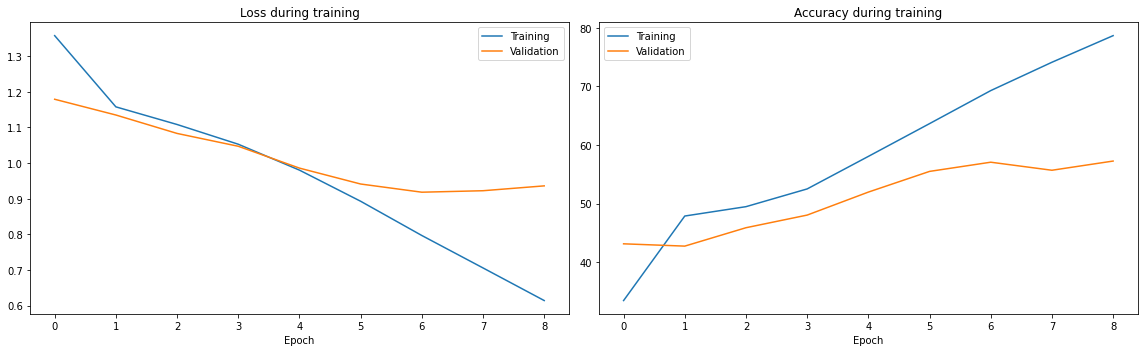

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/hateBERT/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['advanced']['hateBERT'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['hateBERT']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['hateBERT']['f1 score']}]")

Accuracy: [61.49%]
F1 Score: [0.59]


### [B.2.5] HateBERT with LR scheduler (OneCycleLR)

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_category',
                                                                             df=df)

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler=scheduler)

Epoch: 1  Lr: 0.00000431  Loss: Train = [1.3524] - Val = [1.3042]  Accuracy: Train = [34.38%] - Val = [34.12%]  Time one epoch (s): 20.7206 
Epoch: 2  Lr: 0.00000525  Loss: Train = [1.2673] - Val = [1.2438]  Accuracy: Train = [37.28%] - Val = [39.61%]  Time one epoch (s): 20.7245 
Epoch: 3  Lr: 0.00000679  Loss: Train = [1.2018] - Val = [1.1938]  Accuracy: Train = [44.30%] - Val = [45.88%]  Time one epoch (s): 20.1719 
Epoch: 4  Lr: 0.00000892  Loss: Train = [1.1457] - Val = [1.1642]  Accuracy: Train = [48.34%] - Val = [44.51%]  Time one epoch (s): 20.3822 
Epoch: 5  Lr: 0.00001162  Loss: Train = [1.0961] - Val = [1.0983]  Accuracy: Train = [48.80%] - Val = [47.06%]  Time one epoch (s): 20.4092 
Epoch: 6  Lr: 0.00001484  Loss: Train = [1.0173] - Val = [1.0122]  Accuracy: Train = [54.18%] - Val = [53.53%]  Time one epoch (s): 20.3822 
Epoch: 7  Lr: 0.00001855  Loss: Train = [0.9088] - Val = [0.9493]  Accuracy: Train = [61.33%] - Val = [59.22%]  Time one epoch (s): 20.7172 
Epoch: 8  Lr:

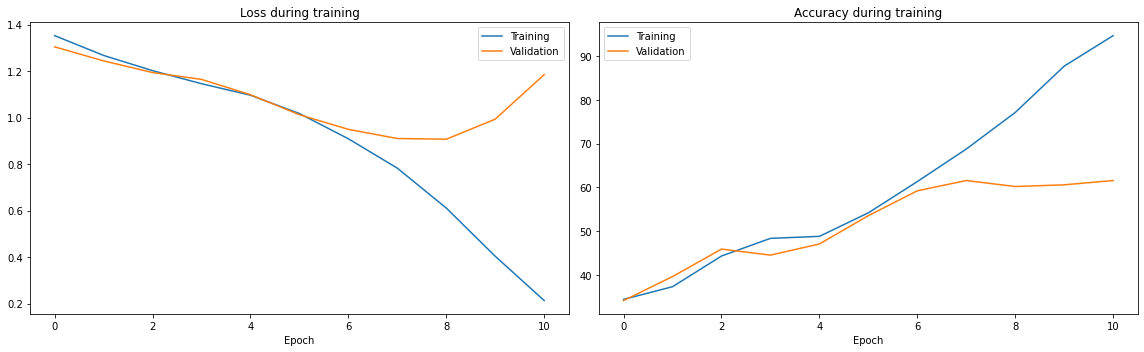

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/hateBERT_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task B']['advanced']['hateBERT_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['hateBERT_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['hateBERT_lr']['f1 score']}]")

Accuracy: [65.23%]
F1 Score: [0.62]


### [B.2.6] Data augmentation

In [ ]:
target_col = 'label_category'
aug_path = '/content/drive/MyDrive/NLP Project/Task B/advanced/augmentation/'

#### Baseline

In [ ]:
df_train, df_val, df_test = split_data(df,False)
df_train = load_aug_train('/content/drive/MyDrive/NLP Project/Augmented_trainings/ContextualWordEmbs_Aug_insert_3_roberta.csv',False)

LSTM model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 'LSTM', 8)

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:47, 5.29MB/s]                            
100%|█████████▉| 1193513/1193514 [00:30<00:00, 39320.13it/s]


Epoch: 1  Lr: 0.00010000  Loss: Train = [1.1893] - Val = [1.1931]  Accuracy: Train = [47.94%] - Val = [43.24%]  Time one epoch (s): 10.8093 
Epoch: 2  Lr: 0.00010000  Loss: Train = [1.1636] - Val = [1.1763]  Accuracy: Train = [47.94%] - Val = [43.24%]  Time one epoch (s): 8.1711 
Epoch: 3  Lr: 0.00010000  Loss: Train = [1.1347] - Val = [1.1234]  Accuracy: Train = [47.89%] - Val = [43.44%]  Time one epoch (s): 9.5651 
Epoch: 4  Lr: 0.00010000  Loss: Train = [1.0735] - Val = [1.1141]  Accuracy: Train = [48.62%] - Val = [42.66%]  Time one epoch (s): 8.9124 
Epoch: 5  Lr: 0.00010000  Loss: Train = [1.0399] - Val = [1.1047]  Accuracy: Train = [49.11%] - Val = [44.40%]  Time one epoch (s): 8.9642 
Epoch: 6  Lr: 0.00010000  Loss: Train = [1.0049] - Val = [1.1325]  Accuracy: Train = [50.81%] - Val = [43.82%]  Time one epoch (s): 9.5341 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.9819] - Val = [1.1427]  Accuracy: Train = [51.38%] - Val = [41.89%]  Time one epoch (s): 8.0508 
--- Early Stopping 

In [ ]:
ground_truth, predictions = simple_return_values(model, dataloaders['test'])
metrics_dict['Task B']['advanced']['augmentation']['lstm'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                              'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['augmentation']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['augmentation']['lstm']['f1 score']}]")

Accuracy: [46.7%]
F1 Score: [0.35]


In [ ]:
model_weights_path = os.path.join(aug_path,'lstm/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

BERTTiny model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'prajjwal1/bert-tiny', 2048)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.3508] - Val = [1.3229]  Accuracy: Train = [42.02%] - Val = [43.24%]  Time one epoch (s): 3.5714 
Epoch: 2  Lr: 0.00010000  Loss: Train = [1.2794] - Val = [1.2722]  Accuracy: Train = [47.72%] - Val = [43.24%]  Time one epoch (s): 2.6015 
Epoch: 3  Lr: 0.00010000  Loss: Train = [1.2353] - Val = [1.2398]  Accuracy: Train = [47.81%] - Val = [43.24%]  Time one epoch (s): 3.2274 
Epoch: 4  Lr: 0.00010000  Loss: Train = [1.2058] - Val = [1.2191]  Accuracy: Train = [47.91%] - Val = [43.24%]  Time one epoch (s): 3.9360 
Epoch: 5  Lr: 0.00010000  Loss: Train = [1.1922] - Val = [1.2070]  Accuracy: Train = [47.74%] - Val = [43.24%]  Time one epoch (s): 2.5024 
Epoch: 6  Lr: 0.00010000  Loss: Train = [1.1806] - Val = [1.2003]  Accuracy: Train = [47.83%] - Val = [43.24%]  Time one epoch (s): 2.5954 
Epoch: 7  Lr: 0.00010000  Loss: Train = [1.1748] - Val = [1.1962]  Accuracy: Train = [47.81%] - Val = [43.24%]  Time one epoch (s): 2.5276 
Epoch: 8  Lr: 0.0001

In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task B']['advanced']['augmentation']['berttiny'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                              'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['augmentation']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['augmentation']['berttiny']['f1 score']}]")

Accuracy: [46.89%]
F1 Score: [0.43]


In [ ]:
model_weights_path = os.path.join(aug_path,'berttiny/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

DistilRoBERTa model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'distilroberta-base', 256)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.1634] - Val = [1.0913]  Accuracy: Train = [45.83%] - Val = [44.40%]  Time one epoch (s): 19.4763 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.9388] - Val = [0.9307]  Accuracy: Train = [55.47%] - Val = [55.41%]  Time one epoch (s): 19.2309 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.6936] - Val = [1.0554]  Accuracy: Train = [69.92%] - Val = [55.79%]  Time one epoch (s): 19.4114 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.4589] - Val = [1.2026]  Accuracy: Train = [81.52%] - Val = [57.72%]  Time one epoch (s): 19.4342 
--- Early Stopping ---
Time for 4 epochs (s): 96.776


In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task B']['advanced']['augmentation']['distilroberta'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                       'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['augmentation']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['augmentation']['distilroberta']['f1 score']}]")

Accuracy: [58.38%]
F1 Score: [0.54]


In [ ]:
model_weights_path = os.path.join(aug_path,'distilroberta/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

#### Best model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'GroNLP/hateBERT', 256,
                                                use_scheduler=True)

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

Epoch: 1  Lr: 0.00000431  Loss: Train = [1.3235] - Val = [1.2878]  Accuracy: Train = [33.82%] - Val = [42.47%]  Time one epoch (s): 38.3574 
Epoch: 2  Lr: 0.00000525  Loss: Train = [1.2118] - Val = [1.2258]  Accuracy: Train = [47.66%] - Val = [43.44%]  Time one epoch (s): 37.3891 
Epoch: 3  Lr: 0.00000679  Loss: Train = [1.1641] - Val = [1.1881]  Accuracy: Train = [47.96%] - Val = [43.44%]  Time one epoch (s): 37.0757 
Epoch: 4  Lr: 0.00000892  Loss: Train = [1.1289] - Val = [1.1550]  Accuracy: Train = [48.02%] - Val = [43.63%]  Time one epoch (s): 37.9169 
Epoch: 5  Lr: 0.00001162  Loss: Train = [1.0884] - Val = [1.1102]  Accuracy: Train = [49.36%] - Val = [44.98%]  Time one epoch (s): 37.4938 
Epoch: 6  Lr: 0.00001484  Loss: Train = [1.0269] - Val = [1.0460]  Accuracy: Train = [52.60%] - Val = [49.81%]  Time one epoch (s): 37.8740 
Epoch: 7  Lr: 0.00001855  Loss: Train = [0.9418] - Val = [0.9722]  Accuracy: Train = [58.22%] - Val = [53.67%]  Time one epoch (s): 37.5111 
Epoch: 8  Lr:

In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task B']['advanced']['augmentation']['hateBERT_lr'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                     'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task B']['advanced']['augmentation']['hateBERT_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task B']['advanced']['augmentation']['hateBERT_lr']['f1 score']}]")

Accuracy: [59.32%]
F1 Score: [0.59]


In [ ]:
model_weights_path = os.path.join(aug_path,'hateBERT_lr/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# Save results
with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Models Comparison

#### Scheduler

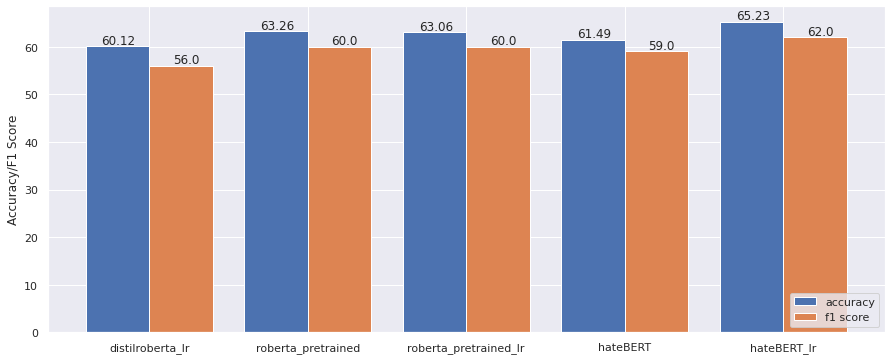

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task B']['advanced'].keys())
accuracies = [metrics_dict['Task B']['advanced'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task B']['advanced'][m]['f1 score'] for m in models]
f1_scores = [round(100 * f, 1) for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

#### Data augmentation
From the graph below, we can see that the baseline has significantly improved as far as `berttiny` and `lstm` models are concerned.

In particular, previously they had an F1 score of 0.16 for `lstm` and 0.35 for `berttiny`. While `distilroberta` had 0.55, therefore its performance has lowered.

Looking at `hateBERT_lr` the F1 score has dropped from 62.0 to 59.0, meaning that the augmented data was not helpful at all, on the contrary, confused the model

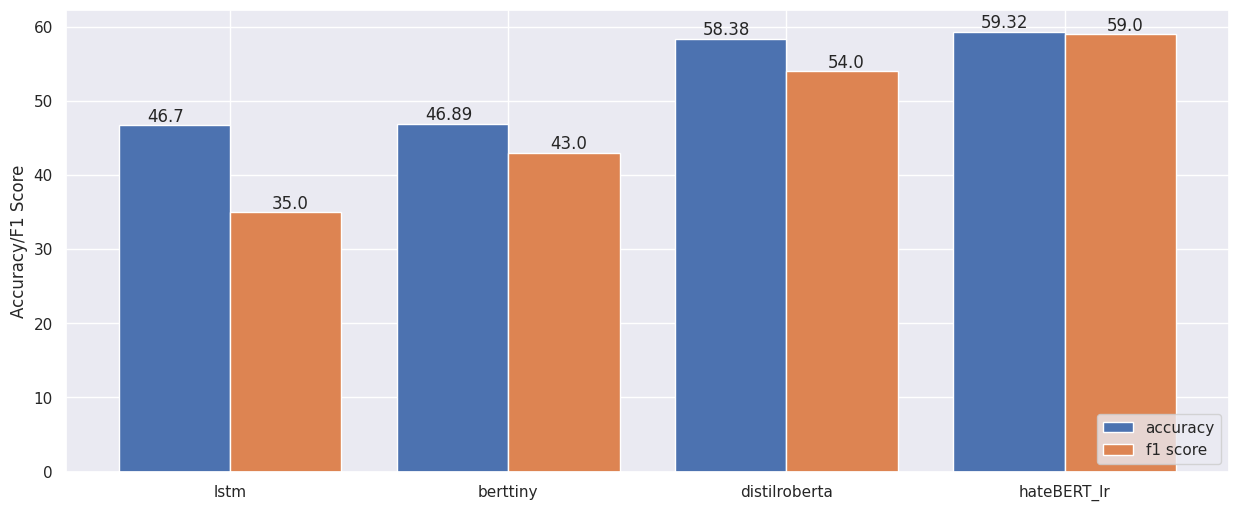

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task B']['advanced']['augmentation'].keys())
accuracies = [metrics_dict['Task B']['advanced']['augmentation'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task B']['advanced']['augmentation'][m]['f1 score'] for m in models]
f1_scores = [100 * f for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

# 🟢 [Task C] Subclassification of sexism

Since the dataset contained both sexist and not sexists sentences, for the task C we had to remove the non sexist phrases, so we had a relevant decrease of data (about the 75%)

In [ ]:
CLASSES= 11
df = df[df['label_sexist'] == "sexist"]
df.head()

## [C.1] Baseline

We used the same baseline models of the task A and B, obtraining the following results:
- **LSTM**
  - Accuracy: [19.41%]
  - F1 Score: [0.03]
- **BERTTiny**
  - Accuracy: [41.06%]
  - F1 Score: [0.21]
- **DistilRoBERTa**
  - Accuracy: [46.37%]
  - F1 Score: [0.28]

### [C.1.1] LSTM with Glove Embedding

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

#### Split Data



In [ ]:
#Here we want to keep the dataframe structure

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text'], x_test, df_train['label_vector'], y_test = train_test_split(df['text'], df['label_vector'], test_size=0.3, random_state = 42)
df_test['text'], df_val['text'], df_test['label_vector'], df_val['label_vector'] = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

In [ ]:
df_train.head()

,text,label_vector
4058,Kids make stupid mistakes like tie up mentally...,4.1 supporting mistreatment of individual women
1912,Read whereareallthegoodmen sub and stay away f...,2.2 aggressive and emotive attacks
7091,"Just keep practicing, is you get as good at it...","3.1 casual use of gendered slurs, profanities,..."
4391,hotter girls have higher bitch shields and shi...,"3.1 casual use of gendered slurs, profanities,..."
11760,"Fuck you, you sanctimonious cunt.","3.1 casual use of gendered slurs, profanities,..."


#### Embedding Phase

In [ ]:
#We'll use the basic_english tokenizer in the torchtext library
tokenizer = get_tokenizer("basic_english")

In [ ]:
#Construct the vocabulary using the previous tokenizer

def build_vocabulary(dataset):
      for text in dataset:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary(df_train['text']), min_freq = 1, specials=["<UNK>", "<PAD>"])
vocab.set_default_index(0)

print(f'The vocabulary contains {len(vocab.get_itos())} tokens')

The vocabulary contains 7990 tokens


In [ ]:
#Let's import GloVe twitter.27B with dimension 50

glove = GloVe(name='twitter.27B', dim=50)
glove.vectors.shape

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:48, 5.27MB/s]                            
100%|█████████▉| 1193513/1193514 [00:29<00:00, 40804.07it/s]


torch.Size([1193514, 50])

In [ ]:
#Let's plug our previous vocabulary with the glove vocabulary
#Note that the OOV words are handled with a zero vector

vocab.vectors = glove.get_vecs_by_tokens(vocab.get_itos())
vocab.vectors.shape

torch.Size([7990, 50])

In [ ]:
train_dataset = SimpleDataset(df_train['text'], df_train['label_vector'], vocab, tokenizer, MAX_LEN)
val_dataset = SimpleDataset(df_val['text'], df_val['label_vector'], vocab, tokenizer, MAX_LEN)
test_dataset = SimpleDataset(df_val['text'], df_val['label_vector'], vocab, tokenizer, MAX_LEN)

print(f'There are {len(train_dataset)} element in the training set')
print(f'There are {len(val_dataset)} element in the training set')
print(f'There are {len(test_dataset)} element in the training set')

There are 2378 element in the training set
There are 510 element in the training set
There are 510 element in the training set


In [ ]:
#Create the two dataloader

train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, VAL_BATCH_SIZE)

#### Model

In [ ]:
class LSTMBaseline(nn.Module):
    def __init__(self, vocab, hidden_dim, layer_dim, output_dim):
        super(LSTMBaseline, self).__init__()

        vocab_size, emb_size = vocab.vectors.shape
        
        self.emb = nn.Embedding(vocab_size, emb_size, _weight = vocab.vectors)

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(emb_size, hidden_dim, layer_dim, batch_first = True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        token_embs = self.emb(x)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        outputs, (h_n, c_n) = self.lstm(token_embs, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        outputs = self.fc(outputs[:, -1, :]) 
        # out.size() --> 100, 10
        return outputs

In [ ]:
model = LSTMBaseline(vocab, 256, 1, CLASSES).to(device)

#### Train

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3,  min_delta = 0)

history = LSTM_training_loop(num_epochs, optimizer, log_interval,
                            model, train_dataloader, val_dataloader,
                            loss_func, early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [2.3888] - Val = [2.3753]  Accuracy: Train = [13.29%] - Val = [20.20%]  Time one epoch (s): 4.6951 
Epoch: 2  Lr: 0.00001000  Loss: Train = [2.3599] - Val = [2.3367]  Accuracy: Train = [20.48%] - Val = [20.20%]  Time one epoch (s): 4.0867 
Epoch: 3  Lr: 0.00001000  Loss: Train = [2.2234] - Val = [2.0838]  Accuracy: Train = [20.48%] - Val = [20.20%]  Time one epoch (s): 4.1543 
Epoch: 4  Lr: 0.00001000  Loss: Train = [2.0857] - Val = [2.0739]  Accuracy: Train = [20.35%] - Val = [20.20%]  Time one epoch (s): 3.6252 
Epoch: 5  Lr: 0.00001000  Loss: Train = [2.0792] - Val = [2.0716]  Accuracy: Train = [20.52%] - Val = [20.20%]  Time one epoch (s): 3.6259 
Epoch: 6  Lr: 0.00001000  Loss: Train = [2.0775] - Val = [2.0705]  Accuracy: Train = [20.35%] - Val = [19.61%]  Time one epoch (s): 4.2060 
Epoch: 7  Lr: 0.00001000  Loss: Train = [2.0763] - Val = [2.0701]  Accuracy: Train = [20.90%] - Val = [19.80%]  Time one epoch (s): 4.1485 
Epoch: 8  Lr: 0.0000

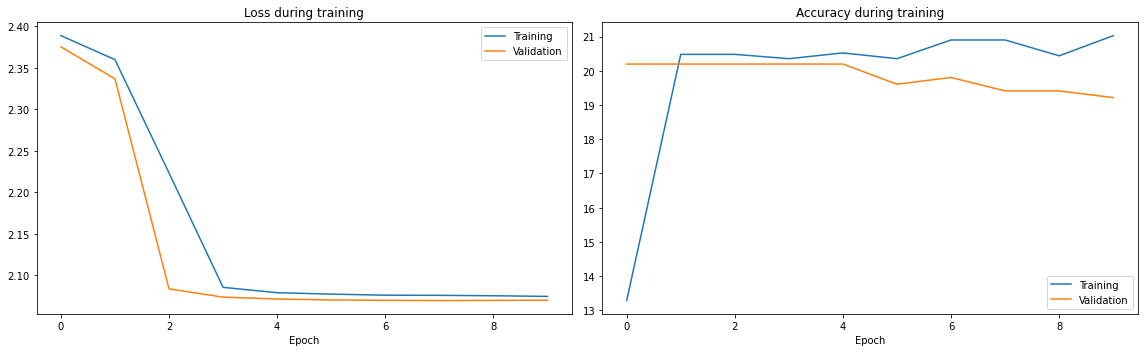

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/baseline/lstm/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation



In [ ]:
grand_truth, predictions = simple_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['baseline']['lstm'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                              'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['baseline']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['baseline']['lstm']['f1 score']}]")

Accuracy: [19.41%]
F1 Score: [0.03]


### [C.1.2] BERTTiny


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=2048,val_bs=2048,test_bs=2048,
                                                                             class_num=CLASSES,
                                                                             model_name='prajjwal1/bert-tiny',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

#### Training

In [ ]:
lr = 1e-4
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [2.4295] - Val = [2.3953]  Accuracy: Train = [7.23%] - Val = [16.47%]  Time one epoch (s): 1.8658 
Epoch: 2  Lr: 0.00010000  Loss: Train = [2.3813] - Val = [2.3577]  Accuracy: Train = [15.89%] - Val = [19.02%]  Time one epoch (s): 1.6982 
Epoch: 3  Lr: 0.00010000  Loss: Train = [2.3464] - Val = [2.3307]  Accuracy: Train = [19.88%] - Val = [18.04%]  Time one epoch (s): 1.6664 
Epoch: 4  Lr: 0.00010000  Loss: Train = [2.3165] - Val = [2.3104]  Accuracy: Train = [21.44%] - Val = [18.04%]  Time one epoch (s): 1.9624 
Epoch: 5  Lr: 0.00010000  Loss: Train = [2.2992] - Val = [2.2931]  Accuracy: Train = [21.61%] - Val = [18.04%]  Time one epoch (s): 2.4706 
Epoch: 6  Lr: 0.00010000  Loss: Train = [2.2810] - Val = [2.2761]  Accuracy: Train = [21.82%] - Val = [18.24%]  Time one epoch (s): 2.1998 
Epoch: 7  Lr: 0.00010000  Loss: Train = [2.2626] - Val = [2.2589]  Accuracy: Train = [21.61%] - Val = [18.24%]  Time one epoch (s): 1.6764 
Epoch: 8  Lr: 0.00010

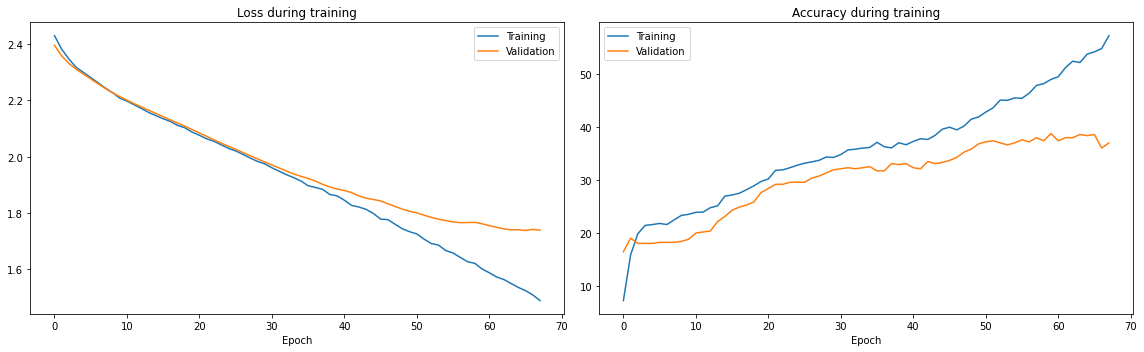

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/baseline/berttiny/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['baseline']['berttiny'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                  'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['baseline']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['baseline']['berttiny']['f1 score']}]")

Accuracy: [41.06%]
F1 Score: [0.21]


### [C.1.3] DistilRoBERTa


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [2.3656] - Val = [2.3212]  Accuracy: Train = [10.59%] - Val = [18.82%]  Time one epoch (s): 9.9186 
Epoch: 2  Lr: 0.00001000  Loss: Train = [2.2399] - Val = [2.1754]  Accuracy: Train = [22.15%] - Val = [18.82%]  Time one epoch (s): 10.0057 
Epoch: 3  Lr: 0.00001000  Loss: Train = [2.0968] - Val = [2.0967]  Accuracy: Train = [23.03%] - Val = [23.53%]  Time one epoch (s): 10.3171 
Epoch: 4  Lr: 0.00001000  Loss: Train = [2.0343] - Val = [2.0322]  Accuracy: Train = [27.45%] - Val = [28.82%]  Time one epoch (s): 10.1526 
Epoch: 5  Lr: 0.00001000  Loss: Train = [1.9619] - Val = [1.9254]  Accuracy: Train = [31.06%] - Val = [31.18%]  Time one epoch (s): 10.4331 
Epoch: 6  Lr: 0.00001000  Loss: Train = [1.8604] - Val = [1.8393]  Accuracy: Train = [35.65%] - Val = [33.53%]  Time one epoch (s): 10.4855 
Epoch: 7  Lr: 0.00001000  Loss: Train = [1.7669] - Val = [1.7865]  Accuracy: Train = [35.35%] - Val = [32.16%]  Time one epoch (s): 10.4819 
Epoch: 8  Lr: 

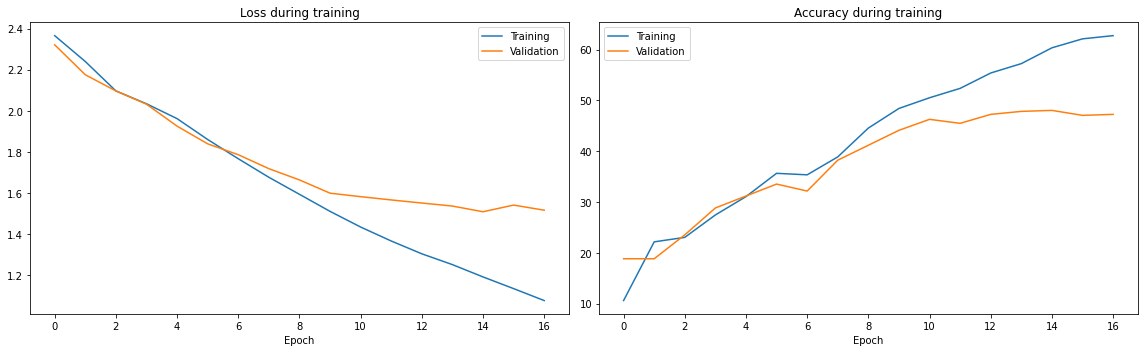

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/baseline/distilroberta/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['baseline']['distilroberta'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['baseline']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['baseline']['distilroberta']['f1 score']}]")

Accuracy: [46.37%]
F1 Score: [0.28]


### Models Comparison



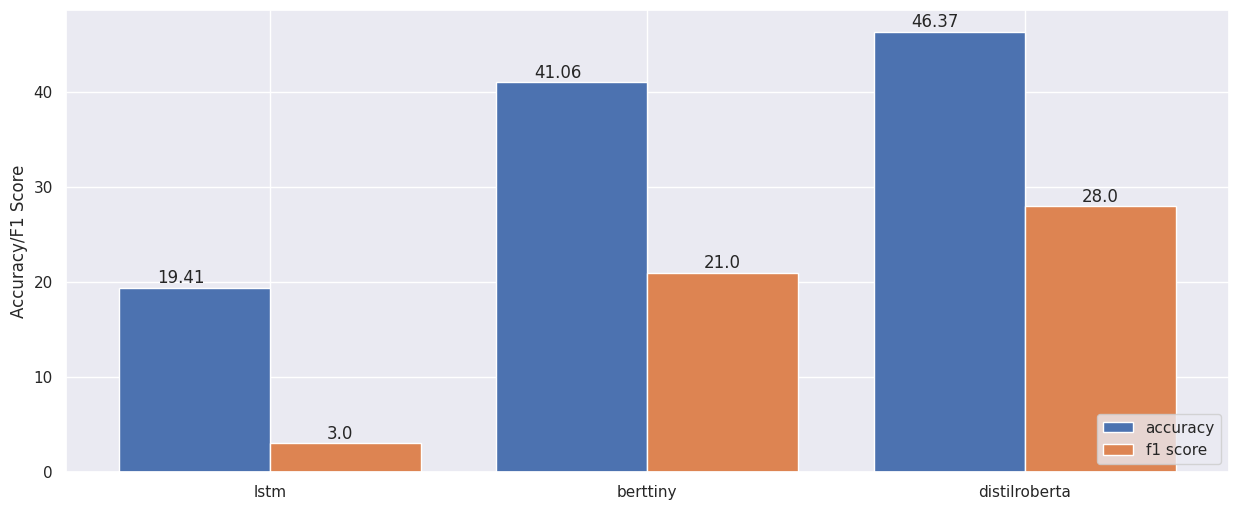

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task C']['baseline'].keys())
accuracies = [metrics_dict['Task C']['baseline'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task C']['baseline'][m]['f1 score'] for m in models]
f1_scores = [round(100 * f,1) for f in f1_scores]


X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

## [C.2] Advanced

We also used the same advanced models of the task A and B, obtraining the following results:
- **DistilRoBERTa** with Learning scheduler (OneCycleLR)
  - Accuracy: [46.17%]
  - F1 Score: [0.32]
- **RoBERTa pretrained** on hate speech dataset
  - Accuracy: [49.12%]
  - F1 Score: [0.31]
- **RoBERTa pretrained** on hate speech dataset with Learning scheduler (OneCycleLR)
  - Accuracy: [42.83%]
  - F1 Score: [0.28]
- **hateBERT**
  - Accuracy: [50.49%]
  - F1 Score: [0.33]
- **hateBERT with Learning scheduler** (OneCycleLR)
  - Accuracy: [50.88%]
  - F1 Score: [0.36]

### [C.2.1] DistilRoBERTa with LR scheduler (OneCycleLR)


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=256,val_bs=256,test_bs=256,
                                                                             class_num=CLASSES,
                                                                             model_name='distilroberta-base',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper,
                        scheduler=scheduler)

Epoch: 1  Lr: 0.00000520  Loss: Train = [2.4608] - Val = [2.4281]  Accuracy: Train = [8.45%] - Val = [8.04%]  Time one epoch (s): 18.0197 
Epoch: 2  Lr: 0.00000875  Loss: Train = [2.4143] - Val = [2.3781]  Accuracy: Train = [8.53%] - Val = [8.04%]  Time one epoch (s): 9.5486 
Epoch: 3  Lr: 0.00001447  Loss: Train = [2.3426] - Val = [2.2736]  Accuracy: Train = [12.32%] - Val = [18.82%]  Time one epoch (s): 10.1925 
Epoch: 4  Lr: 0.00002207  Loss: Train = [2.1767] - Val = [2.0762]  Accuracy: Train = [20.64%] - Val = [21.18%]  Time one epoch (s): 9.9424 
Epoch: 5  Lr: 0.00003117  Loss: Train = [2.0346] - Val = [1.9787]  Accuracy: Train = [25.05%] - Val = [29.80%]  Time one epoch (s): 9.6445 
Epoch: 6  Lr: 0.00004132  Loss: Train = [1.8929] - Val = [1.7958]  Accuracy: Train = [31.57%] - Val = [33.14%]  Time one epoch (s): 10.2788 
Epoch: 7  Lr: 0.00005200  Loss: Train = [1.7069] - Val = [1.6340]  Accuracy: Train = [36.44%] - Val = [37.45%]  Time one epoch (s): 10.0683 
Epoch: 8  Lr: 0.0000

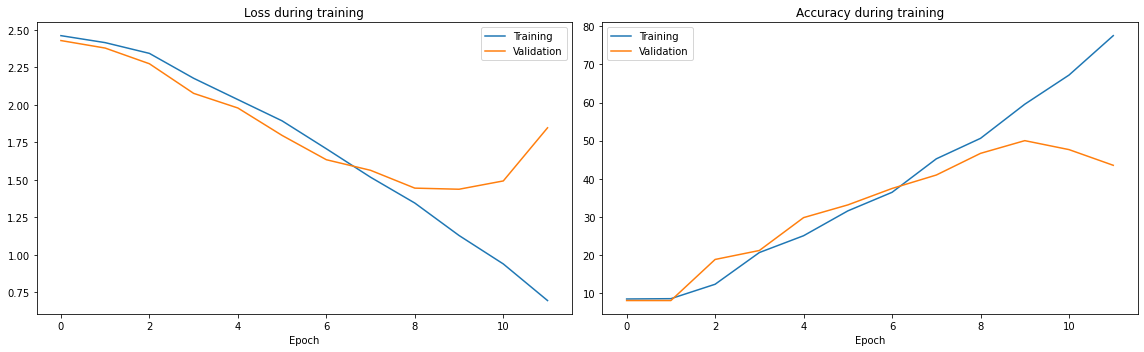

In [ ]:
display_history(history)

#### Load and Save

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/distilroberta_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['advanced']['distilroberta_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                       'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['distilroberta_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['distilroberta_lr']['f1 score']}]")

Accuracy: [46.17%]
F1 Score: [0.32]


### [C.2.2] RoBERTa pretrained on hate speech


In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [2.1675] - Val = [1.9933]  Accuracy: Train = [24.25%] - Val = [35.29%]  Time one epoch (s): 20.8246 
Epoch: 2  Lr: 0.00001000  Loss: Train = [1.9118] - Val = [1.8004]  Accuracy: Train = [35.81%] - Val = [37.25%]  Time one epoch (s): 21.1320 
Epoch: 3  Lr: 0.00001000  Loss: Train = [1.7420] - Val = [1.6919]  Accuracy: Train = [39.39%] - Val = [39.41%]  Time one epoch (s): 20.9767 
Epoch: 4  Lr: 0.00001000  Loss: Train = [1.5874] - Val = [1.6067]  Accuracy: Train = [45.73%] - Val = [42.16%]  Time one epoch (s): 21.2196 
Epoch: 5  Lr: 0.00001000  Loss: Train = [1.4457] - Val = [1.5382]  Accuracy: Train = [51.74%] - Val = [44.90%]  Time one epoch (s): 21.4556 
Epoch: 6  Lr: 0.00001000  Loss: Train = [1.3074] - Val = [1.4795]  Accuracy: Train = [57.71%] - Val = [47.25%]  Time one epoch (s): 21.2580 
Epoch: 7  Lr: 0.00001000  Loss: Train = [1.1920] - Val = [1.4416]  Accuracy: Train = [62.97%] - Val = [49.61%]  Time one epoch (s): 21.9292 
Epoch: 8  Lr:

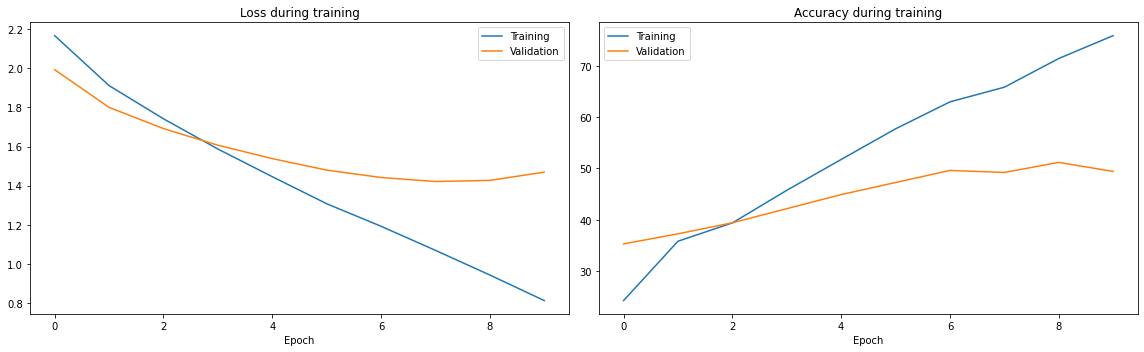

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/roberta_pretrained/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['advanced']['roberta_pretrained'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                  'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['roberta_pretrained']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['roberta_pretrained']['f1 score']}]")

Accuracy: [49.12%]
F1 Score: [0.31]


### [C.2.3] RoBERTa pretrained on Hate Speech Dataset with LR scheduler (OneCycleLR)

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='cardiffnlp/twitter-roberta-base-hate',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )
loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler = scheduler)

Epoch: 1  Lr: 0.00000431  Loss: Train = [2.3062] - Val = [2.1577]  Accuracy: Train = [15.89%] - Val = [27.84%]  Time one epoch (s): 22.3518 
Epoch: 2  Lr: 0.00000525  Loss: Train = [2.1039] - Val = [2.0021]  Accuracy: Train = [26.73%] - Val = [36.27%]  Time one epoch (s): 21.5564 
Epoch: 3  Lr: 0.00000679  Loss: Train = [1.9955] - Val = [1.8976]  Accuracy: Train = [33.46%] - Val = [36.86%]  Time one epoch (s): 22.0127 
Epoch: 4  Lr: 0.00000892  Loss: Train = [1.8821] - Val = [1.7689]  Accuracy: Train = [36.65%] - Val = [38.43%]  Time one epoch (s): 21.9866 
Epoch: 5  Lr: 0.00001162  Loss: Train = [1.7577] - Val = [1.6532]  Accuracy: Train = [39.26%] - Val = [41.37%]  Time one epoch (s): 22.1590 
Epoch: 6  Lr: 0.00001484  Loss: Train = [1.5971] - Val = [1.5248]  Accuracy: Train = [46.20%] - Val = [44.51%]  Time one epoch (s): 21.9359 
Epoch: 7  Lr: 0.00001855  Loss: Train = [1.4091] - Val = [1.4386]  Accuracy: Train = [53.59%] - Val = [50.20%]  Time one epoch (s): 22.1826 
Epoch: 8  Lr:

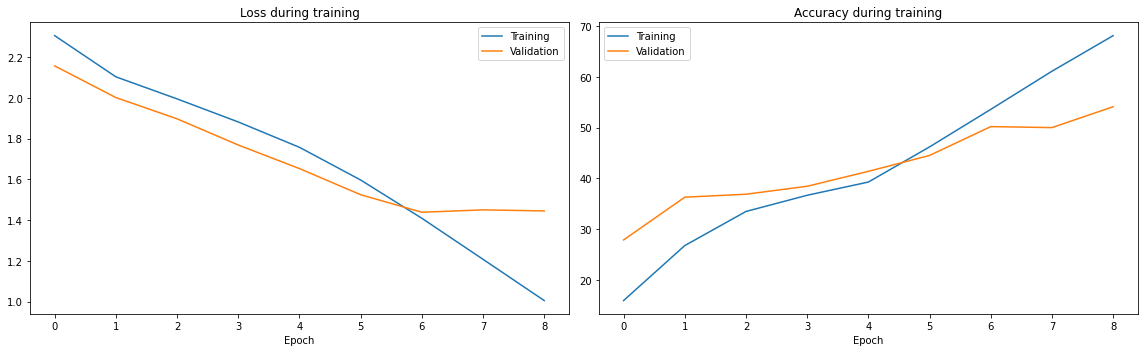

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/roberta_pretrained_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['advanced']['roberta_pretrained_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                               'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['roberta_pretrained_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['roberta_pretrained_lr']['f1 score']}]")

Accuracy: [42.83%]
F1 Score: [0.28]


### [C.2.4] HateBERT

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00001000  Loss: Train = [2.3960] - Val = [2.2484]  Accuracy: Train = [16.14%] - Val = [25.49%]  Time one epoch (s): 22.2495 
Epoch: 2  Lr: 0.00001000  Loss: Train = [2.1801] - Val = [2.0535]  Accuracy: Train = [21.86%] - Val = [29.41%]  Time one epoch (s): 22.2591 
Epoch: 3  Lr: 0.00001000  Loss: Train = [1.9941] - Val = [1.9147]  Accuracy: Train = [30.85%] - Val = [34.12%]  Time one epoch (s): 22.2694 
Epoch: 4  Lr: 0.00001000  Loss: Train = [1.8630] - Val = [1.8270]  Accuracy: Train = [36.65%] - Val = [37.25%]  Time one epoch (s): 21.9708 
Epoch: 5  Lr: 0.00001000  Loss: Train = [1.7505] - Val = [1.7549]  Accuracy: Train = [42.24%] - Val = [40.39%]  Time one epoch (s): 22.1414 
Epoch: 6  Lr: 0.00001000  Loss: Train = [1.6448] - Val = [1.6929]  Accuracy: Train = [46.20%] - Val = [42.35%]  Time one epoch (s): 22.0282 
Epoch: 7  Lr: 0.00001000  Loss: Train = [1.5513] - Val = [1.6355]  Accuracy: Train = [50.23%] - Val = [44.51%]  Time one epoch (s): 22.2636 
Epoch: 8  Lr:

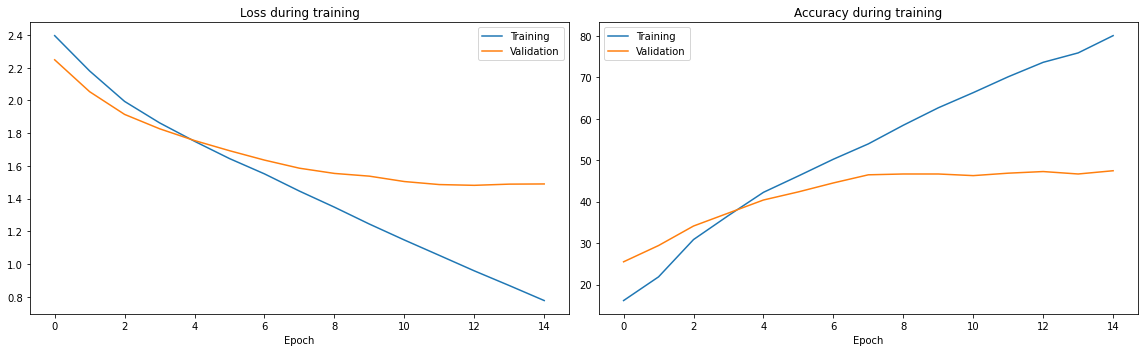

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/hateBERT/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['advanced']['hateBERT'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['hateBERT']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['hateBERT']['f1 score']}]")

Accuracy: [50.49%]
F1 Score: [0.33]


### [C.2.5] HateBERT with LR scheduler (OneCycleLR)

In [ ]:
model, train_dataloader, val_dataloader, test_dataloader = define_model_conf(train_bs=128,val_bs=128,test_bs=128,
                                                                             class_num=CLASSES,
                                                                             model_name='GroNLP/hateBERT',
                                                                             label_name='label_vector',
                                                                             df=df)

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

#### Training

In [ ]:
lr = 1e-5
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, 
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=5
                                                )

loss_func = torch.nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience = 3, min_delta = 0)

In [ ]:
history = training_loop(num_epochs, optimizer, log_interval,
                        model, train_dataloader, val_dataloader,
                        loss_func, train_transformer, validate_transformer,
                        early_stopping = early_stopper, scheduler=scheduler)

Epoch: 1  Lr: 0.00000431  Loss: Train = [2.3384] - Val = [2.2935]  Accuracy: Train = [7.86%] - Val = [7.45%]  Time one epoch (s): 22.5445 
Epoch: 2  Lr: 0.00000525  Loss: Train = [2.2423] - Val = [2.2083]  Accuracy: Train = [14.71%] - Val = [23.33%]  Time one epoch (s): 22.5836 
Epoch: 3  Lr: 0.00000679  Loss: Train = [2.1487] - Val = [2.1173]  Accuracy: Train = [26.52%] - Val = [30.00%]  Time one epoch (s): 21.8604 
Epoch: 4  Lr: 0.00000892  Loss: Train = [2.0427] - Val = [2.0307]  Accuracy: Train = [33.04%] - Val = [30.98%]  Time one epoch (s): 22.1555 
Epoch: 5  Lr: 0.00001162  Loss: Train = [1.9415] - Val = [1.9445]  Accuracy: Train = [35.01%] - Val = [33.14%]  Time one epoch (s): 22.0931 
Epoch: 6  Lr: 0.00001484  Loss: Train = [1.8416] - Val = [1.8703]  Accuracy: Train = [37.96%] - Val = [33.73%]  Time one epoch (s): 22.1907 
Epoch: 7  Lr: 0.00001855  Loss: Train = [1.7314] - Val = [1.7973]  Accuracy: Train = [40.52%] - Val = [34.12%]  Time one epoch (s): 22.0917 
Epoch: 8  Lr: 0

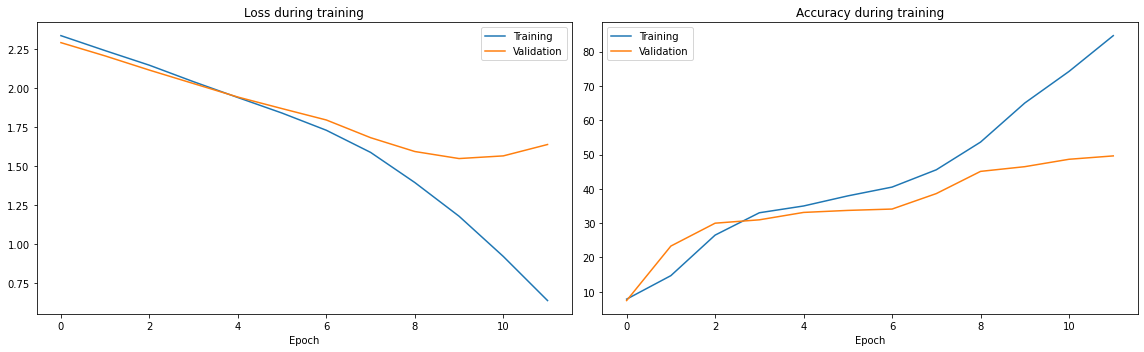

In [ ]:
display_history(history)

#### Save and Load

In [ ]:
model_weights_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/hateBERT_lr/weigth.pth'

#SAVE
torch.save(model.state_dict(), model_weights_path)

#LOAD
model.load_state_dict(torch.load(model_weights_path, map_location = device))

<All keys matched successfully>

#### Simple Evaluation

In [ ]:
grand_truth, predictions = transformers_return_values(model, test_dataloader)

In [ ]:
metrics_dict['Task C']['advanced']['hateBERT_lr'] = {'accuracy' : round(accuracy_score(grand_truth, predictions, )*100, 2),
                                                    'f1 score' : round(f1_score(grand_truth, predictions, average = "macro"),2)}

with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['hateBERT_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['hateBERT_lr']['f1 score']}]")

Accuracy: [50.88%]
F1 Score: [0.36]


### [C.2.6] Data augmentation

In [ ]:
target_col = 'label_vector'
aug_path = '/content/drive/MyDrive/NLP Project/Task C/advanced/augmentation/'

#### Baseline

In [ ]:
df_train, df_val, df_test = split_data(df,False)
df_train = load_aug_train('/content/drive/MyDrive/NLP Project/Augmented_trainings/ContextualWordEmbs_Aug_insert_3_roberta.csv',False)

LSTM model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 'LSTM', 8)

Epoch: 1  Lr: 0.00010000  Loss: Train = [2.1053] - Val = [2.1155]  Accuracy: Train = [19.71%] - Val = [17.76%]  Time one epoch (s): 10.6331 
Epoch: 2  Lr: 0.00010000  Loss: Train = [2.0463] - Val = [2.1220]  Accuracy: Train = [21.54%] - Val = [17.76%]  Time one epoch (s): 11.3029 
Epoch: 3  Lr: 0.00010000  Loss: Train = [2.0438] - Val = [2.1049]  Accuracy: Train = [22.03%] - Val = [18.92%]  Time one epoch (s): 12.8313 
Epoch: 4  Lr: 0.00010000  Loss: Train = [2.0411] - Val = [2.0978]  Accuracy: Train = [21.84%] - Val = [21.43%]  Time one epoch (s): 18.0663 
Epoch: 5  Lr: 0.00010000  Loss: Train = [2.0008] - Val = [2.0034]  Accuracy: Train = [26.84%] - Val = [27.61%]  Time one epoch (s): 13.6088 
Epoch: 6  Lr: 0.00010000  Loss: Train = [1.9328] - Val = [1.9806]  Accuracy: Train = [29.50%] - Val = [28.76%]  Time one epoch (s): 11.6775 
Epoch: 7  Lr: 0.00010000  Loss: Train = [1.9006] - Val = [1.9838]  Accuracy: Train = [30.74%] - Val = [28.76%]  Time one epoch (s): 9.2144 
Epoch: 8  Lr: 

In [ ]:
ground_truth, predictions = simple_return_values(model, dataloaders['test'])
metrics_dict['Task C']['advanced']['augmentation']['lstm'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                              'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['augmentation']['lstm']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['augmentation']['lstm']['f1 score']}]")

Accuracy: [32.2%]
F1 Score: [0.1]


In [ ]:
model_weights_path = os.path.join(aug_path,'lstm/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

BERTTiny model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'prajjwal1/bert-tiny', 2048)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Epoch: 1  Lr: 0.00010000  Loss: Train = [2.3691] - Val = [2.3206]  Accuracy: Train = [10.81%] - Val = [21.43%]  Time one epoch (s): 3.9011 
Epoch: 2  Lr: 0.00010000  Loss: Train = [2.3104] - Val = [2.2796]  Accuracy: Train = [19.41%] - Val = [20.85%]  Time one epoch (s): 2.5735 
Epoch: 3  Lr: 0.00010000  Loss: Train = [2.2678] - Val = [2.2439]  Accuracy: Train = [20.88%] - Val = [21.43%]  Time one epoch (s): 2.5684 
Epoch: 4  Lr: 0.00010000  Loss: Train = [2.2292] - Val = [2.2204]  Accuracy: Train = [20.99%] - Val = [21.62%]  Time one epoch (s): 2.5667 
Epoch: 5  Lr: 0.00010000  Loss: Train = [2.2015] - Val = [2.2033]  Accuracy: Train = [21.37%] - Val = [19.88%]  Time one epoch (s): 3.8647 
Epoch: 6  Lr: 0.00010000  Loss: Train = [2.1821] - Val = [2.1885]  Accuracy: Train = [21.35%] - Val = [21.24%]  Time one epoch (s): 3.5776 
Epoch: 7  Lr: 0.00010000  Loss: Train = [2.1641] - Val = [2.1749]  Accuracy: Train = [22.86%] - Val = [21.43%]  Time one epoch (s): 2.5802 
Epoch: 8  Lr: 0.0001

In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task C']['advanced']['augmentation']['berttiny'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                  'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['augmentation']['berttiny']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['augmentation']['berttiny']['f1 score']}]")

Accuracy: [35.22%]
F1 Score: [0.19]


In [ ]:
model_weights_path = os.path.join(aug_path,'berttiny/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

DistilRoBERTa model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'distilroberta-base', 256)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.9625] - Val = [1.7418]  Accuracy: Train = [28.52%] - Val = [36.49%]  Time one epoch (s): 19.7000 
Epoch: 2  Lr: 0.00010000  Loss: Train = [1.4781] - Val = [1.5750]  Accuracy: Train = [47.13%] - Val = [42.28%]  Time one epoch (s): 19.5545 
Epoch: 3  Lr: 0.00010000  Loss: Train = [1.0349] - Val = [1.6743]  Accuracy: Train = [64.45%] - Val = [42.86%]  Time one epoch (s): 19.4328 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.6579] - Val = [1.9491]  Accuracy: Train = [78.25%] - Val = [43.44%]  Time one epoch (s): 21.1812 
--- Early Stopping ---
Time for 4 epochs (s): 98.934


In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task C']['advanced']['augmentation']['distilroberta'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                       'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['augmentation']['distilroberta']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['augmentation']['distilroberta']['f1 score']}]")

Accuracy: [46.7%]
F1 Score: [0.35]


In [ ]:
model_weights_path = os.path.join(aug_path,'distilroberta/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

#### Best model

In [ ]:
history, model, dataloaders = prepare_and_train(target_col, df_train, df_val, df_test, 
                                                'GroNLP/hateBERT', 128,
                                                use_scheduler=True)

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

Epoch: 1  Lr: 0.00000408  Loss: Train = [2.3186] - Val = [2.2620]  Accuracy: Train = [13.03%] - Val = [17.95%]  Time one epoch (s): 39.5639 
Epoch: 2  Lr: 0.00000432  Loss: Train = [2.1582] - Val = [2.1555]  Accuracy: Train = [19.09%] - Val = [18.34%]  Time one epoch (s): 39.7073 
Epoch: 3  Lr: 0.00000472  Loss: Train = [2.0569] - Val = [2.0784]  Accuracy: Train = [26.07%] - Val = [26.06%]  Time one epoch (s): 38.9953 
Epoch: 4  Lr: 0.00000527  Loss: Train = [1.9739] - Val = [2.0007]  Accuracy: Train = [32.40%] - Val = [34.17%]  Time one epoch (s): 39.2519 
Epoch: 5  Lr: 0.00000598  Loss: Train = [1.8833] - Val = [1.9168]  Accuracy: Train = [36.04%] - Val = [34.56%]  Time one epoch (s): 39.8687 
Epoch: 6  Lr: 0.00000684  Loss: Train = [1.7890] - Val = [1.8333]  Accuracy: Train = [39.38%] - Val = [37.07%]  Time one epoch (s): 39.0972 
Epoch: 7  Lr: 0.00000785  Loss: Train = [1.6883] - Val = [1.7449]  Accuracy: Train = [43.04%] - Val = [39.58%]  Time one epoch (s): 39.3789 
Epoch: 8  Lr:

In [ ]:
ground_truth, predictions = transformers_return_values(model, dataloaders['test'])
metrics_dict['Task C']['advanced']['augmentation']['hateBERT_lr'] = {'accuracy' : round(accuracy_score(ground_truth, predictions, )*100, 2),
                                                                     'f1 score' : round(f1_score(ground_truth, predictions, average = 'macro'),2)}
print(f"Accuracy: [{metrics_dict['Task C']['advanced']['augmentation']['hateBERT_lr']['accuracy']}%]")
print(f"F1 Score: [{metrics_dict['Task C']['advanced']['augmentation']['hateBERT_lr']['f1 score']}]")

Accuracy: [50.47%]
F1 Score: [0.34]


In [ ]:
model_weights_path = os.path.join(aug_path,'hateBERT_lr/weigth.pth')
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# Save results
with open('/content/drive/MyDrive/NLP Project/metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Models Comparison

#### Scheduler

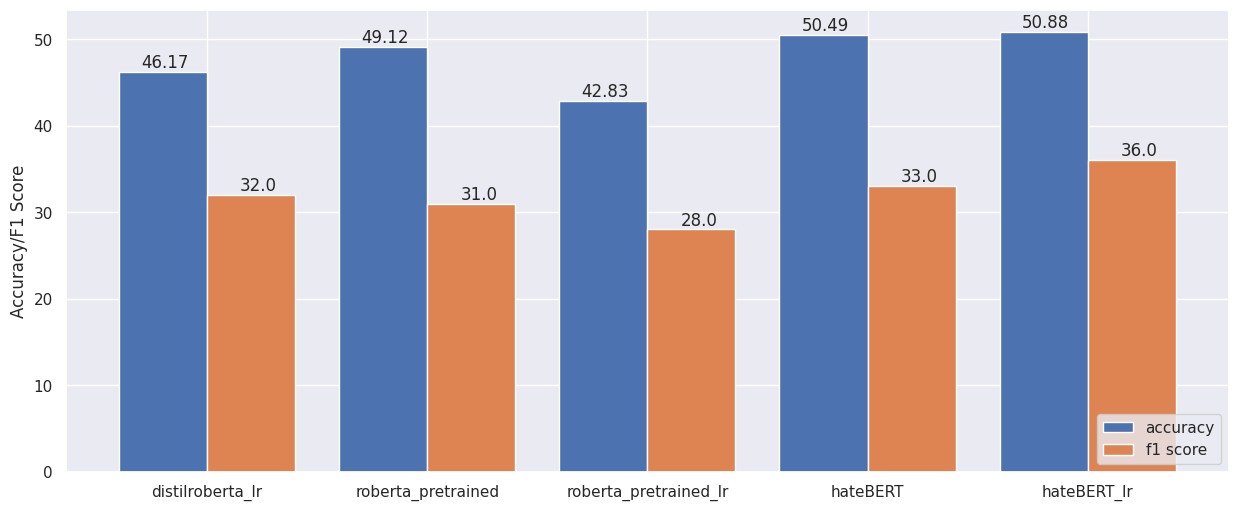

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task C']['advanced'].keys())
accuracies = [metrics_dict['Task C']['advanced'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task C']['advanced'][m]['f1 score'] for m in models]
f1_scores = [round(100 * f,1) for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()

#### Data Augmentation
In Task C, apart from the `distilroberta` model, which dramatically increased the F1 score from 0.28 to 0.35 and the `lstm` one, from 0.03 to 0.1 all the others have experienced a drop in their performance.

It is worth pointing out that `berttiny` might have gained one or two more points (e.g. 0.1 or 0.2) w.r.t. baseline if instead of using the training set augmented by `roberta-base`, we would've used the one augmented by `bert-base-cased`.





 

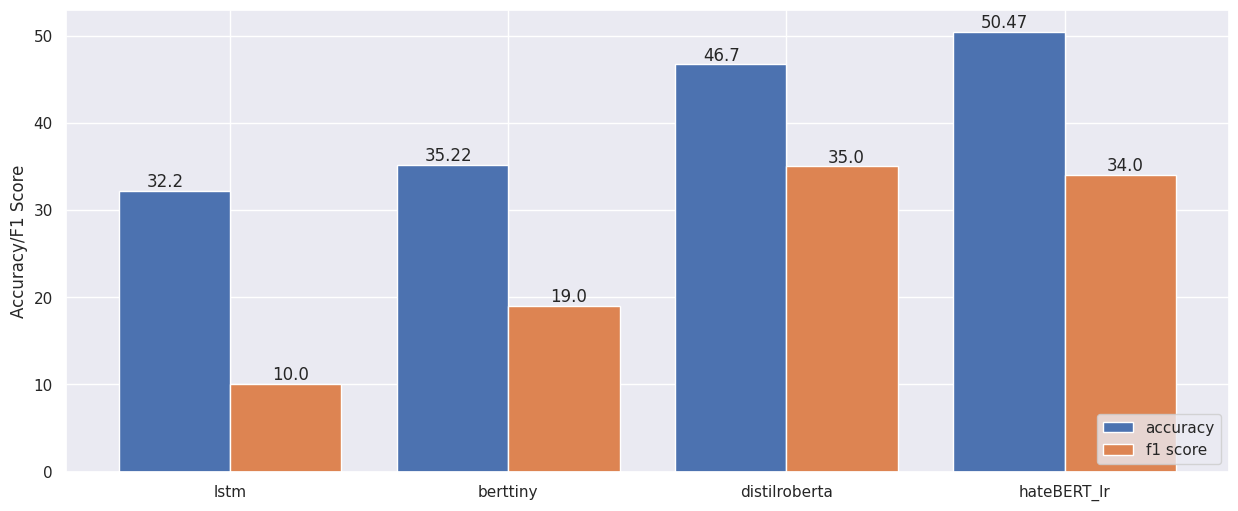

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

models = list(metrics_dict['Task C']['advanced']['augmentation'].keys())
accuracies = [metrics_dict['Task C']['advanced']['augmentation'][m]['accuracy'] for m in models]
f1_scores = [metrics_dict['Task C']['advanced']['augmentation'][m]['f1 score'] for m in models]
f1_scores = [100 * f for f in f1_scores]

X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'f1 score')

for idx, a, f in zip(range(len(models)), accuracies, f1_scores):
  plt.text(X_axis[idx] - 0.3, a + 0.5 , a)
  plt.text(X_axis[idx] + 0.15, f + 0.5, f)
  
plt.xticks(X_axis, models)
plt.ylabel("Accuracy/F1 Score")
plt.legend(loc='lower right')
plt.show()